# Hypothesis Testing: Improving Embedding Quantization for Vector Search

This notebook tests specific hypotheses from the reasoning context:
- **Q2**: Per-dimension weighting for asymmetric binary search
- **Q3**: 2-bit (ternary & quaternary) quantization
- **Q4**: Optimal thresholds beyond median
- **Q5**: Why does median hurt at full dimension?
- **Q6**: Mixed-precision Matryoshka quantization
- **Q7**: Information-theoretic bounds
- **Q8**: Pareto front visualization

## 1. Setup and Data Loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, List, Set, Tuple, Optional
import time
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
PROJECT_ROOT = Path("/Users/haakno/Documents/Research work/vespa/quantization_tests")
sys.path.insert(0, str(PROJECT_ROOT))

from data_loader import MTEBDataLoader
from metrics import RetrievalMetrics
from config import MODELS, DATASETS, K_VALUES

# Cache dirs
CACHE_DIR = PROJECT_ROOT / "cache"
EMBEDDING_DIR = CACHE_DIR / "embeddings"

# ─── Helper functions ───
def load_embeddings(model_key: str, dataset: str):
    """Load cached corpus and query embeddings."""
    corpus_path = EMBEDDING_DIR / f"{model_key}_{dataset}_corpus.npy"
    query_path = EMBEDDING_DIR / f"{model_key}_{dataset}_queries.npy"
    corpus_emb = np.load(corpus_path)
    query_emb = np.load(query_path)
    return corpus_emb.astype(np.float32), query_emb.astype(np.float32)

def truncate_and_normalize(emb: np.ndarray, dim: int) -> np.ndarray:
    """Matryoshka truncation + L2 normalization."""
    t = emb[:, :dim].copy()
    norms = np.linalg.norm(t, axis=1, keepdims=True)
    norms = np.where(norms == 0, 1.0, norms)
    return t / norms

def packbits(x: np.ndarray) -> np.ndarray:
    """Binarize (x > 0) and pack into uint8."""
    return np.packbits((x > 0).astype(np.uint8), axis=1)

def unpack_to_pm1(packed: np.ndarray, dim: int) -> np.ndarray:
    """Unpack binary to {-1, +1} float32."""
    unpacked = np.unpackbits(packed, axis=1)[:, :dim].astype(np.float32)
    return 2.0 * unpacked - 1.0

def search_topk(scores: np.ndarray, k: int) -> np.ndarray:
    """Get top-k indices from similarity scores (higher = better)."""
    k = min(k, scores.shape[1])
    indices = np.argpartition(-scores, k, axis=1)[:, :k]
    for i in range(len(indices)):
        idx = indices[i]
        indices[i] = idx[np.argsort(-scores[i, idx])]
    return indices

def evaluate_indices(indices: np.ndarray, qrels: Dict, doc_id_to_idx: Dict, 
                     query_ids: List[str], k: int = 10) -> Dict[str, float]:
    """Compute NDCG@k and Recall@k from retrieved indices."""
    return RetrievalMetrics.compute_all_metrics(indices, qrels, doc_id_to_idx, query_ids, [k])

# ─── Load all datasets ───
data_loader = MTEBDataLoader(CACHE_DIR / "datasets")

# Models and datasets to test
MODELS_TO_TEST = ["mxbai-embed-large-v1", "nomic-embed-text-v1.5"]
DATASETS_TO_TEST = ["scifact", "nfcorpus"]

# Store everything in a dict for easy access
data = {}
for model_key in MODELS_TO_TEST:
    for dataset in DATASETS_TO_TEST:
        try:
            corpus_emb, query_emb = load_embeddings(model_key, dataset)
            # Capitalize dataset name to match BEIR naming
            dataset_beir = dataset
            if dataset == "nfcorpus":
                dataset_beir = "nfcorpus"
            corpus, queries, qrels = data_loader.load_dataset(dataset_beir)
            doc_ids = list(corpus.keys())
            query_ids = list(queries.keys())
            doc_id_to_idx = {did: i for i, did in enumerate(doc_ids)}
            
            data[(model_key, dataset)] = {
                "corpus_emb": corpus_emb,
                "query_emb": query_emb,
                "qrels": qrels,
                "doc_ids": doc_ids,
                "query_ids": query_ids,
                "doc_id_to_idx": doc_id_to_idx,
            }
            print(f"✓ Loaded {model_key} / {dataset}: corpus={corpus_emb.shape}, queries={query_emb.shape}")
        except Exception as e:
            print(f"✗ Failed to load {model_key} / {dataset}: {e}")

print(f"\nLoaded {len(data)} model/dataset combinations")

Loading cached scifact from /Users/haakno/Documents/Research work/vespa/quantization_tests/cache/datasets/scifact_data.pkl
✓ Loaded mxbai-embed-large-v1 / scifact: corpus=(5183, 1024), queries=(1109, 1024)
Loading cached nfcorpus from /Users/haakno/Documents/Research work/vespa/quantization_tests/cache/datasets/nfcorpus_data.pkl
✓ Loaded mxbai-embed-large-v1 / nfcorpus: corpus=(3633, 1024), queries=(3237, 1024)
Loading cached scifact from /Users/haakno/Documents/Research work/vespa/quantization_tests/cache/datasets/scifact_data.pkl
✓ Loaded nomic-embed-text-v1.5 / scifact: corpus=(5183, 768), queries=(1109, 768)
Loading cached nfcorpus from /Users/haakno/Documents/Research work/vespa/quantization_tests/cache/datasets/nfcorpus_data.pkl
✓ Loaded nomic-embed-text-v1.5 / nfcorpus: corpus=(3633, 768), queries=(3237, 768)

Loaded 4 model/dataset combinations


## 2. Q5: Why Does Median Hurt at Full Dimension?

**Three hypotheses:**
1. **Already zero-centered**: Full-dim L2-normalized embeddings from well-trained models have per-dim medians ≈ 0. Centering adds estimation noise without benefit.
2. **Median estimation noise**: With small corpus (3-5K docs), the median estimate has std ≈ 1.253·σ/√n. If |median| < estimation noise, centering is dominated by noise.
3. **L2-normalization + sphere geometry**: On a d-dimensional unit sphere, projections concentrate around 0 with std ∝ 1/√d. Higher d → smaller medians → less benefit from centering.

Let's test all three.

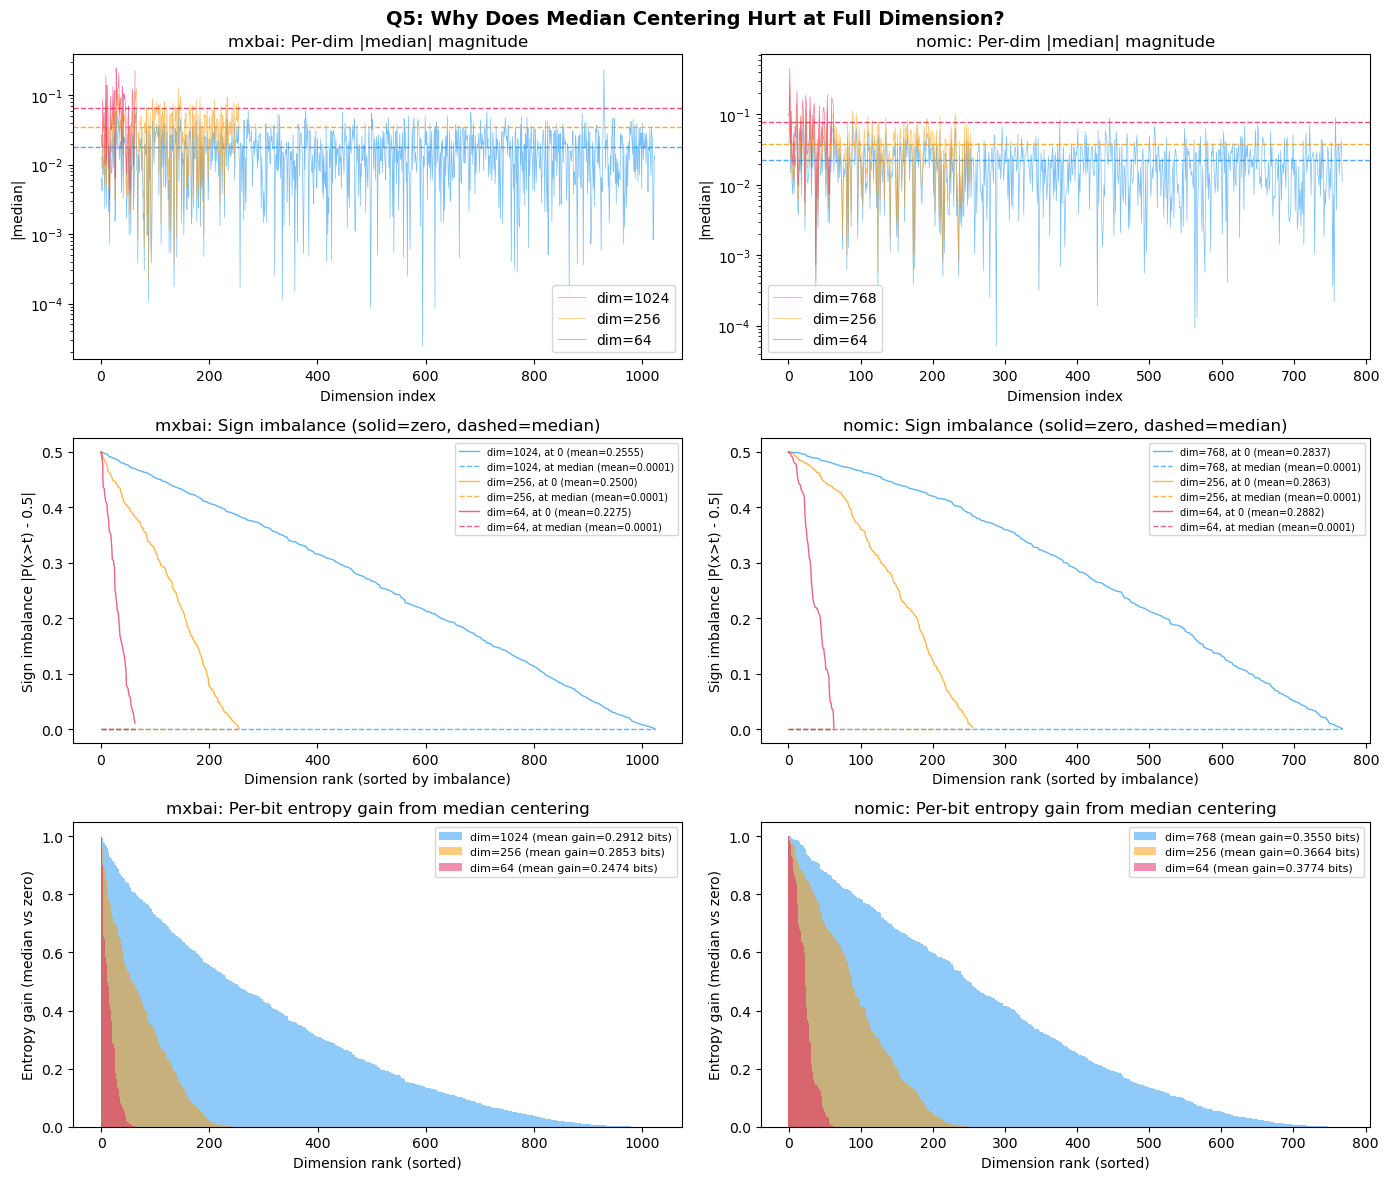

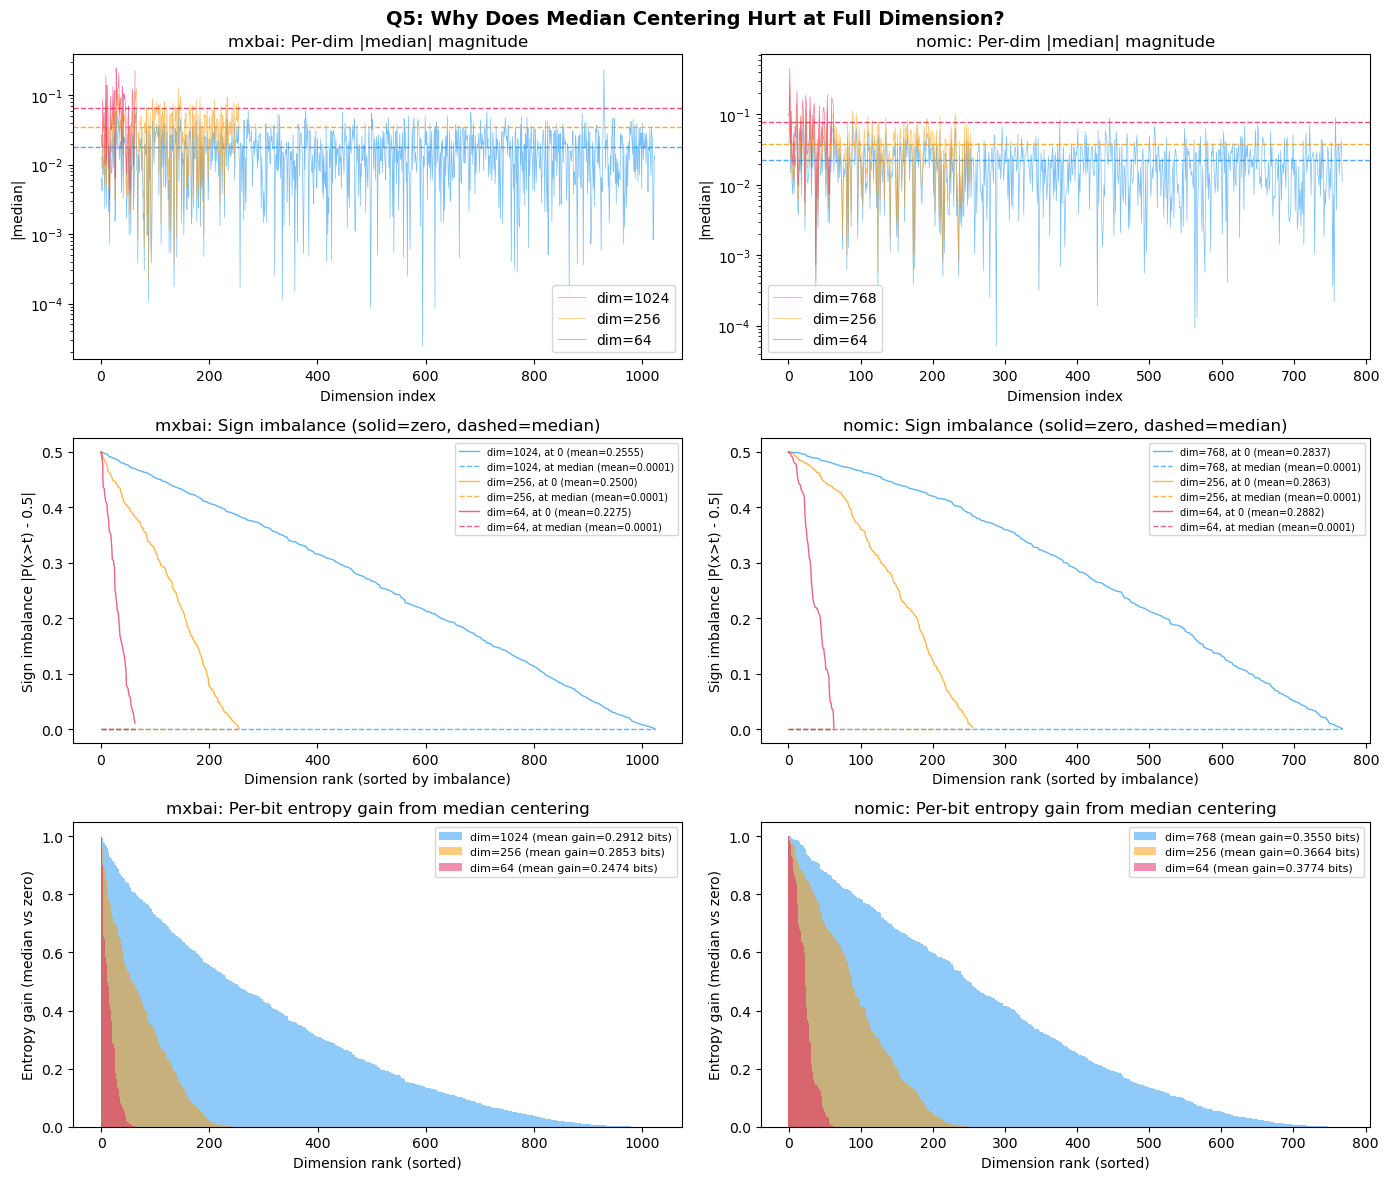


SUMMARY: Per-dimension statistics across Matryoshka dimensions
Model        Dataset      Dim  Mean|med|   Mean std    Imbal@0  Imbal@med    Ent@0  Ent@med  Ent gain
------------------------------------------------------------------------------------------
mxbai        scifact     1024   0.017673   0.021437   0.255494   0.000096   0.7088   1.0000   +0.2912
mxbai        scifact      256   0.035306   0.044393   0.250017   0.000096   0.7147   1.0000   +0.2853
mxbai        scifact      128   0.048133   0.063146   0.237259   0.000096   0.7289   1.0000   +0.2711
mxbai        scifact       64   0.066134   0.090797   0.227532   0.000096   0.7526   1.0000   +0.2474
mxbai        nfcorpus    1024   0.018860   0.019901   0.277577   0.000142   0.6608   1.0000   +0.3392
mxbai        nfcorpus     256   0.038475   0.041532   0.277074   0.000140   0.6634   1.0000   +0.3366
mxbai        nfcorpus     128   0.054471   0.058882   0.278252   0.000140   0.6687   1.0000   +0.3313
mxbai        nfcorpus      64

In [2]:
# ─── Q5: Diagnostic analysis of median centering ───

def binary_entropy(p):
    """H(p) for binary variable."""
    p = np.clip(p, 1e-10, 1 - 1e-10)
    return -p * np.log2(p) - (1 - p) * np.log2(1 - p)

fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle("Q5: Why Does Median Centering Hurt at Full Dimension?", fontsize=14, fontweight='bold')

for col_idx, (model_key, dataset) in enumerate([
    ("mxbai-embed-large-v1", "scifact"), 
    ("nomic-embed-text-v1.5", "scifact")
]):
    d = data[(model_key, dataset)]
    corpus = d["corpus_emb"]
    full_dim = corpus.shape[1]
    model_short = "mxbai" if "mxbai" in model_key else "nomic"
    
    # Test at multiple Matryoshka dimensions
    dims_to_test = [full_dim, 256, 64]
    colors = ['#2196F3', '#FF9800', '#E91E63']
    
    # ─── Panel 1: Per-dim median magnitude vs dimension index ───
    ax = axes[0, col_idx]
    for dim, color in zip(dims_to_test, colors):
        emb = truncate_and_normalize(corpus, dim)
        medians = np.median(emb, axis=0)
        ax.plot(range(dim), np.abs(medians), alpha=0.6, linewidth=0.5, color=color, label=f"dim={dim}")
        ax.axhline(y=np.mean(np.abs(medians)), color=color, linestyle='--', alpha=0.8, linewidth=1)
    ax.set_xlabel("Dimension index")
    ax.set_ylabel("|median|")
    ax.set_title(f"{model_short}: Per-dim |median| magnitude")
    ax.legend()
    ax.set_yscale('log')
    
    # ─── Panel 2: Sign imbalance at zero vs median ───
    ax = axes[1, col_idx]
    for dim, color in zip(dims_to_test, colors):
        emb = truncate_and_normalize(corpus, dim)
        frac_pos_zero = np.mean(emb > 0, axis=0)
        frac_pos_median = np.mean((emb - np.median(emb, axis=0)) > 0, axis=0)
        
        imbalance_zero = np.abs(frac_pos_zero - 0.5)
        imbalance_median = np.abs(frac_pos_median - 0.5)
        
        # Sort by dimension index and plot
        ax.plot(range(dim), np.sort(imbalance_zero)[::-1], color=color, alpha=0.7, 
                linewidth=1, label=f"dim={dim}, at 0 (mean={np.mean(imbalance_zero):.4f})")
        ax.plot(range(dim), np.sort(imbalance_median)[::-1], color=color, alpha=0.7, 
                linewidth=1, linestyle='--', label=f"dim={dim}, at median (mean={np.mean(imbalance_median):.4f})")
    ax.set_xlabel("Dimension rank (sorted by imbalance)")
    ax.set_ylabel("Sign imbalance |P(x>t) - 0.5|")
    ax.set_title(f"{model_short}: Sign imbalance (solid=zero, dashed=median)")
    ax.legend(fontsize=7)
    
    # ─── Panel 3: Entropy improvement ───
    ax = axes[2, col_idx]
    for dim, color in zip(dims_to_test, colors):
        emb = truncate_and_normalize(corpus, dim)
        frac_pos_zero = np.mean(emb > 0, axis=0)
        frac_pos_median = np.mean((emb - np.median(emb, axis=0)) > 0, axis=0)
        
        ent_zero = binary_entropy(frac_pos_zero)
        ent_median = binary_entropy(frac_pos_median)
        ent_gain = ent_median - ent_zero  # positive = median is better
        
        ax.bar(range(dim), np.sort(ent_gain)[::-1], color=color, alpha=0.5, 
               width=1, label=f"dim={dim} (mean gain={np.mean(ent_gain):.4f} bits)")
    ax.axhline(y=0, color='black', linewidth=0.5)
    ax.set_xlabel("Dimension rank (sorted)")
    ax.set_ylabel("Entropy gain (median vs zero)")
    ax.set_title(f"{model_short}: Per-bit entropy gain from median centering")
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

# ─── Quantitative summary ───
print("\n" + "=" * 90)
print("SUMMARY: Per-dimension statistics across Matryoshka dimensions")
print("=" * 90)
print(f"{'Model':<12} {'Dataset':<10} {'Dim':>5} {'Mean|med|':>10} {'Mean std':>10} "
      f"{'Imbal@0':>10} {'Imbal@med':>10} {'Ent@0':>8} {'Ent@med':>8} {'Ent gain':>9}")
print("-" * 90)

for model_key in MODELS_TO_TEST:
    for dataset in DATASETS_TO_TEST:
        if (model_key, dataset) not in data:
            continue
        d = data[(model_key, dataset)]
        corpus = d["corpus_emb"]
        full_dim = corpus.shape[1]
        model_short = model_key.split("-")[0]
        
        for dim in [full_dim, 256, 128, 64]:
            if dim > full_dim:
                continue
            emb = truncate_and_normalize(corpus, dim)
            medians = np.median(emb, axis=0)
            stds = np.std(emb, axis=0)
            
            frac_pos_zero = np.mean(emb > 0, axis=0)
            frac_pos_med = np.mean((emb - medians) > 0, axis=0)
            
            imbal_zero = np.mean(np.abs(frac_pos_zero - 0.5))
            imbal_med = np.mean(np.abs(frac_pos_med - 0.5))
            ent_zero = np.mean(binary_entropy(frac_pos_zero))
            ent_med = np.mean(binary_entropy(frac_pos_med))
            
            print(f"{model_short:<12} {dataset:<10} {dim:>5} {np.mean(np.abs(medians)):>10.6f} "
                  f"{np.mean(stds):>10.6f} {imbal_zero:>10.6f} {imbal_med:>10.6f} "
                  f"{ent_zero:>8.4f} {ent_med:>8.4f} {ent_med - ent_zero:>+9.4f}")

## 3. Q2: Per-Dimension Weighting for Asymmetric Binary Search

**Theory**: In standard `binary_asym`, the score is $q^T \text{sign}(d)$. This implicitly reconstructs each corpus dimension as $\hat{d}_i = \text{sign}(d_i)$, which has unit magnitude regardless of the actual scale.

The **optimal reconstruction** minimizes $\mathbb{E}[(d_i - w_i \cdot \text{sign}(d_i - t_i))^2]$:
$$w_i^* = \mathbb{E}[|d_i - t_i|]$$

This is the **mean absolute deviation** from the threshold. With this weighting, the reconstructed corpus better approximates the true corpus, improving score fidelity.

We test three variants:
1. `binary_weighted_asym`: $w_i = \mathbb{E}[|d_i|]$ (threshold at 0)
2. `binary_median_weighted_asym`: $w_i = \mathbb{E}[|d_i - m_i|]$ (threshold at median)
3. `binary_std_asym`: $w_i = \sigma_i$ (standard deviation weighting)

In [3]:
# ─── Q2: Per-dimension weighting experiments ───

def run_binary_asym(query_emb, corpus_emb, k=100):
    """Standard binary asymmetric: q^T sign(d)."""
    binary_corpus = packbits(corpus_emb)
    unpacked = unpack_to_pm1(binary_corpus, corpus_emb.shape[1])
    scores = query_emb @ unpacked.T
    return search_topk(scores, k)

def run_binary_median_asym(query_emb, corpus_emb, k=100):
    """Binary median asymmetric: (q-m)^T sign(d-m)."""
    medians = np.median(corpus_emb, axis=0)
    c_centered = corpus_emb - medians
    q_centered = query_emb - medians
    binary_corpus = packbits(c_centered)
    unpacked = unpack_to_pm1(binary_corpus, corpus_emb.shape[1])
    scores = q_centered @ unpacked.T
    return search_topk(scores, k)

def run_binary_weighted_asym(query_emb, corpus_emb, k=100, use_median=False):
    """Weighted binary asymmetric: q^T (w * sign(d-t)) where w_i = E[|d_i - t_i|]."""
    if use_median:
        thresholds = np.median(corpus_emb, axis=0)
    else:
        thresholds = np.zeros(corpus_emb.shape[1], dtype=np.float32)
    
    centered = corpus_emb - thresholds
    weights = np.mean(np.abs(centered), axis=0)  # w_i = E[|d_i - t_i|]
    
    binary_corpus = packbits(centered)
    unpacked = unpack_to_pm1(binary_corpus, corpus_emb.shape[1])
    # Apply weights to the unpacked binary corpus
    unpacked_weighted = unpacked * weights
    
    q_centered = query_emb - thresholds
    scores = q_centered @ unpacked_weighted.T
    return search_topk(scores, k)

def run_binary_std_asym(query_emb, corpus_emb, k=100, use_median=False):
    """Std-weighted binary asymmetric: q^T (sigma * sign(d-t))."""
    if use_median:
        thresholds = np.median(corpus_emb, axis=0)
    else:
        thresholds = np.zeros(corpus_emb.shape[1], dtype=np.float32)
    
    centered = corpus_emb - thresholds
    weights = np.std(centered, axis=0)  # w_i = std(d_i - t_i)
    
    binary_corpus = packbits(centered)
    unpacked = unpack_to_pm1(binary_corpus, corpus_emb.shape[1])
    unpacked_weighted = unpacked * weights
    
    q_centered = query_emb - thresholds
    scores = q_centered @ unpacked_weighted.T
    return search_topk(scores, k)

# ─── Run experiments ───
print("=" * 100)
print("Q2: Per-Dimension Weighting for Binary Asymmetric Search — NDCG@10")
print("=" * 100)

methods = {
    "binary_asym": run_binary_asym,
    "binary_med_asym": run_binary_median_asym,
    "binary_w_asym (t=0)": lambda q, c, k=100: run_binary_weighted_asym(q, c, k, use_median=False),
    "binary_w_asym (t=med)": lambda q, c, k=100: run_binary_weighted_asym(q, c, k, use_median=True),
    "binary_std_asym (t=0)": lambda q, c, k=100: run_binary_std_asym(q, c, k, use_median=False),
    "binary_std_asym (t=med)": lambda q, c, k=100: run_binary_std_asym(q, c, k, use_median=True),
}

results_q2 = {}

for model_key in MODELS_TO_TEST:
    for dataset in DATASETS_TO_TEST:
        if (model_key, dataset) not in data:
            continue
        d = data[(model_key, dataset)]
        full_dim = d["corpus_emb"].shape[1]
        model_short = model_key.split("-")[0]
        
        dims = [full_dim, 256, 128, 64]
        
        print(f"\n{'─'*50}")
        print(f"  {model_short} / {dataset}")
        print(f"{'─'*50}")
        print(f"  {'Method':<28} ", end="")
        for dim in dims:
            print(f"{'dim=' + str(dim):>10}", end="")
        print()
        print(f"  {'─'*28} " + "─" * 10 * len(dims))
        
        for method_name, method_fn in methods.items():
            print(f"  {method_name:<28} ", end="")
            for dim in dims:
                if dim > full_dim:
                    print(f"{'—':>10}", end="")
                    continue
                
                corpus = truncate_and_normalize(d["corpus_emb"], dim)
                queries = truncate_and_normalize(d["query_emb"], dim)
                
                indices = method_fn(queries, corpus)
                metrics = evaluate_indices(indices, d["qrels"], d["doc_id_to_idx"], d["query_ids"])
                ndcg = metrics.get("ndcg@10", 0)
                results_q2[(model_key, dataset, method_name, dim)] = ndcg
                print(f"{ndcg:>10.4f}", end="")
            print()
        
        # Also show float32 baseline
        print(f"  {'--- float32 baseline ---':<28} ", end="")
        for dim in dims:
            if dim > full_dim:
                print(f"{'—':>10}", end="")
                continue
            corpus = truncate_and_normalize(d["corpus_emb"], dim)
            queries = truncate_and_normalize(d["query_emb"], dim)
            scores = queries @ corpus.T
            indices = search_topk(scores, 100)
            metrics = evaluate_indices(indices, d["qrels"], d["doc_id_to_idx"], d["query_ids"])
            print(f"{metrics.get('ndcg@10', 0):>10.4f}", end="")
        print()

Q2: Per-Dimension Weighting for Binary Asymmetric Search — NDCG@10

──────────────────────────────────────────────────
  mxbai / scifact
──────────────────────────────────────────────────
  Method                         dim=1024   dim=256   dim=128    dim=64
  ──────────────────────────── ────────────────────────────────────────
  binary_asym                      0.7292    0.6240    0.5210    0.3493
  binary_med_asym                  0.7259    0.6534    0.5688    0.4536
  binary_w_asym (t=0)              0.7244    0.6100    0.5044    0.3424
  binary_w_asym (t=med)            0.7241    0.6500    0.5725    0.4515
  binary_std_asym (t=0)            0.7252    0.6239    0.5151    0.3525
  binary_std_asym (t=med)          0.7241    0.6502    0.5717    0.4523
  --- float32 baseline ---         0.7389    0.6932    0.6714    0.5985

──────────────────────────────────────────────────
  mxbai / nfcorpus
──────────────────────────────────────────────────
  Method                         dim=1024 

## 4. Q3: 2-Bit Quantization (Ternary and Quaternary)

**Ternary** ({-1, 0, +1}): A dead zone $[-t, +t]$ maps uncertain dimensions to 0.
- Optimal $t^* ≈ 0.675σ$ (for Gaussian data, this puts 50% in the dead zone)
- Asymmetric score: $q^T \text{ternary}(d)$ — zero-valued dims contribute nothing (soft feature selection)

**Quaternary** ({0,1,2,3}): 4 levels using quartile boundaries.
- Centroid reconstruction: each code maps to the mean of its quartile
- 2 bits/dim = 1/4 byte/dim = 16x compression (vs 32x for binary, 4x for int8)

Both are truly **2 bits/dim**, sitting in the gap between binary and int8.

In [4]:
# ─── Q3: 2-bit quantization implementations ───

def quantize_ternary(corpus_emb, t_factor=0.675, use_median=True):
    """
    Ternary quantization: {-1, 0, +1}.
    
    Args:
        corpus_emb: (n, d) float32
        t_factor: dead zone width as fraction of std (0.675 = Gaussian optimal)
        use_median: whether to center at median first
    
    Returns:
        ternary: (n, d) int8 in {-1, 0, +1}
        thresholds: (d,) centering thresholds
        t: (d,) dead zone widths
        recon_weights: (d,) optimal reconstruction weights for non-zero entries
    """
    if use_median:
        thresholds = np.median(corpus_emb, axis=0)
    else:
        thresholds = np.zeros(corpus_emb.shape[1], dtype=np.float32)
    
    centered = corpus_emb - thresholds
    stds = np.std(centered, axis=0)
    t = t_factor * stds
    
    ternary = np.zeros_like(centered, dtype=np.int8)
    ternary[centered > t] = 1
    ternary[centered < -t] = -1
    
    # Optimal reconstruction weight for non-zero entries: E[|d_i| | |d_i| > t_i]
    recon_weights = np.zeros(corpus_emb.shape[1], dtype=np.float32)
    for d in range(corpus_emb.shape[1]):
        mask = np.abs(centered[:, d]) > t[d]
        if mask.sum() > 0:
            recon_weights[d] = np.mean(np.abs(centered[mask, d]))
        else:
            recon_weights[d] = stds[d]
    
    return ternary, thresholds, t, recon_weights


def quantize_quaternary(corpus_emb):
    """
    Quaternary quantization: 4 levels using quartile boundaries.
    
    Returns:
        codes: (n, d) uint8 in {0, 1, 2, 3}
        boundaries: (3, d) — 25th, 50th, 75th percentile boundaries
        centroids: (4, d) — reconstruction centroid per code per dim
    """
    boundaries = np.percentile(corpus_emb, [25, 50, 75], axis=0)  # (3, d)
    p25, p50, p75 = boundaries
    
    codes = np.zeros_like(corpus_emb, dtype=np.uint8)
    codes[corpus_emb >= p25] = 1
    codes[corpus_emb >= p50] = 2
    codes[corpus_emb >= p75] = 3
    
    # Compute centroids (mean of each quartile per dim)
    dim = corpus_emb.shape[1]
    centroids = np.zeros((4, dim), dtype=np.float32)
    for c in range(4):
        mask = codes == c
        for d in range(dim):
            vals = corpus_emb[mask[:, d], d]
            centroids[c, d] = vals.mean() if len(vals) > 0 else (c - 1.5) * np.std(corpus_emb[:, d])
    
    return codes, boundaries, centroids


def run_ternary_asym(query_emb, corpus_emb, k=100, t_factor=0.675, use_median=True, use_weights=True):
    """Asymmetric ternary search."""
    if use_median:
        thresholds = np.median(corpus_emb, axis=0)
    else:
        thresholds = np.zeros(corpus_emb.shape[1], dtype=np.float32)
    
    ternary, thresholds, t, recon_weights = quantize_ternary(corpus_emb, t_factor, use_median)
    
    corpus_float = ternary.astype(np.float32)
    if use_weights:
        corpus_float *= recon_weights  # Scale non-zero entries by E[|d_i| | |d_i| > t]
    
    q_centered = query_emb - thresholds
    scores = q_centered @ corpus_float.T
    return search_topk(scores, k)


def run_quaternary_asym(query_emb, corpus_emb, k=100):
    """Asymmetric quaternary search."""
    codes, boundaries, centroids = quantize_quaternary(corpus_emb)
    
    # Reconstruct corpus from codes: centroids[codes[i,j], j]
    dim = corpus_emb.shape[1]
    reconstructed = centroids[codes, np.arange(dim)]
    
    scores = query_emb @ reconstructed.T
    return search_topk(scores, k)


# ─── Run 2-bit experiments ───
print("=" * 110)
print("Q3: 2-Bit Quantization — NDCG@10")
print("=" * 110)

methods_2bit = {
    "binary_asym (1 bit)": lambda q, c, k=100: run_binary_asym(q, c, k),
    "binary_med_asym (1 bit)": lambda q, c, k=100: run_binary_median_asym(q, c, k),
    "ternary_asym (2 bit, t=0)": lambda q, c, k=100: run_ternary_asym(q, c, k, use_median=False),
    "ternary_asym (2 bit, t=med)": lambda q, c, k=100: run_ternary_asym(q, c, k, use_median=True),
    "ternary_asym (t=med, no w)": lambda q, c, k=100: run_ternary_asym(q, c, k, use_median=True, use_weights=False),
    "quaternary_asym (2 bit)": lambda q, c, k=100: run_quaternary_asym(q, c, k),
}

# Also test different dead-zone widths for ternary
ternary_t_sweep = [0.3, 0.5, 0.675, 0.8, 1.0, 1.5]

results_q3 = {}

for model_key in MODELS_TO_TEST:
    for dataset in DATASETS_TO_TEST:
        if (model_key, dataset) not in data:
            continue
        d = data[(model_key, dataset)]
        full_dim = d["corpus_emb"].shape[1]
        model_short = model_key.split("-")[0]
        
        dims = [full_dim, 256, 128, 64]
        
        print(f"\n{'─'*60}")
        print(f"  {model_short} / {dataset}")
        print(f"{'─'*60}")
        print(f"  {'Method':<32} ", end="")
        for dim in dims:
            print(f"{'dim=' + str(dim):>10}", end="")
        print(f"  {'bits/dim':>8}")
        print(f"  {'─'*32} " + "─" * (10 * len(dims) + 10))
        
        for method_name, method_fn in methods_2bit.items():
            bits = 1 if "1 bit" in method_name else 2
            print(f"  {method_name:<32} ", end="")
            for dim in dims:
                if dim > full_dim:
                    print(f"{'—':>10}", end="")
                    continue
                corpus = truncate_and_normalize(d["corpus_emb"], dim)
                queries = truncate_and_normalize(d["query_emb"], dim)
                
                indices = method_fn(queries, corpus)
                metrics = evaluate_indices(indices, d["qrels"], d["doc_id_to_idx"], d["query_ids"])
                ndcg = metrics.get("ndcg@10", 0)
                results_q3[(model_key, dataset, method_name, dim)] = ndcg
                print(f"{ndcg:>10.4f}", end="")
            print(f"  {bits:>8}")
        
        # Float32 baseline
        print(f"  {'--- float32 baseline ---':<32} ", end="")
        for dim in dims:
            if dim > full_dim:
                print(f"{'—':>10}", end="")
                continue
            corpus = truncate_and_normalize(d["corpus_emb"], dim)
            queries = truncate_and_normalize(d["query_emb"], dim)
            scores = queries @ corpus.T
            indices = search_topk(scores, 100)
            metrics = evaluate_indices(indices, d["qrels"], d["doc_id_to_idx"], d["query_ids"])
            print(f"{metrics.get('ndcg@10', 0):>10.4f}", end="")
        print(f"  {32:>8}")

# ─── Ternary t-factor sweep ───
print(f"\n\n{'='*90}")
print("Ternary dead-zone sweep (t_factor × σ): NDCG@10 at dim=256")
print(f"{'='*90}")
print(f"  {'Model':<10} {'Dataset':<10}", end="")
for t in ternary_t_sweep:
    print(f"  t={t:<6.3f}", end="")
print()

for model_key in MODELS_TO_TEST:
    for dataset in DATASETS_TO_TEST:
        if (model_key, dataset) not in data:
            continue
        d = data[(model_key, dataset)]
        model_short = model_key.split("-")[0]
        dim = 256
        corpus = truncate_and_normalize(d["corpus_emb"], dim)
        queries = truncate_and_normalize(d["query_emb"], dim)
        
        print(f"  {model_short:<10} {dataset:<10}", end="")
        for t_factor in ternary_t_sweep:
            indices = run_ternary_asym(queries, corpus, t_factor=t_factor, use_median=True)
            metrics = evaluate_indices(indices, d["qrels"], d["doc_id_to_idx"], d["query_ids"])
            print(f"  {metrics.get('ndcg@10', 0):<8.4f}", end="")
        print()

Q3: 2-Bit Quantization — NDCG@10

────────────────────────────────────────────────────────────
  mxbai / scifact
────────────────────────────────────────────────────────────
  Method                             dim=1024   dim=256   dim=128    dim=64  bits/dim
  ──────────────────────────────── ──────────────────────────────────────────────────
  binary_asym (1 bit)                  0.7292    0.6240    0.5210    0.3493         1
  binary_med_asym (1 bit)              0.7259    0.6534    0.5688    0.4536         1
  ternary_asym (2 bit, t=0)            0.7391    0.6283    0.5213    0.3968         2
  ternary_asym (2 bit, t=med)          0.7256    0.6454    0.6038    0.4781         2
  ternary_asym (t=med, no w)           0.7273    0.6465    0.6029    0.4777         2
  quaternary_asym (2 bit)              0.7407    0.6643    0.6016    0.4768         2
  --- float32 baseline ---             0.7389    0.6932    0.6714    0.5985        32

───────────────────────────────────────────────────

## 5. Q6: Mixed-Precision Matryoshka Quantization

For Matryoshka models, early dimensions carry more signal. A **mixed-precision** scheme keeps early dims at high precision (float32 or int8) and binarizes the rest.

**Storage for 512d with 64-float + 448-binary split:**
- Float part: 64 × 4 = 256 bytes
- Binary part: 448 / 8 = 56 bytes  
- **Total: 312 bytes** (6.6× compression vs float32's 2048 bytes)
- Compare: pure binary = 64 bytes (32×), pure int8 = 512 bytes (4×)

Score: $s = \alpha \cdot q_{\text{float}}^T d_{\text{float}} + \beta \cdot q_{\text{bin}}^T \text{sign}(d_{\text{bin}})$

In [5]:
# ─── Q6: Mixed-precision Matryoshka ───

def run_mixed_precision(query_emb, corpus_emb, float_dims, binary_dims, 
                        k=100, use_median=True):
    """
    Mixed-precision: float32 for early dims, binary_asym for late dims.
    Score = (q_f^T d_f) / sqrt(float_dims) + (q_b^T sign(d_b)) / sqrt(binary_dims)
    """
    total_dims = float_dims + binary_dims
    
    # Float32 part (early dimensions)
    q_f = query_emb[:, :float_dims]
    c_f = corpus_emb[:, :float_dims]
    float_scores = q_f @ c_f.T
    
    # Binary part (later dimensions)
    q_b = query_emb[:, float_dims:total_dims]
    c_b = corpus_emb[:, float_dims:total_dims]
    
    if use_median:
        med = np.median(c_b, axis=0)
        c_b_centered = c_b - med
        q_b_centered = q_b - med
    else:
        c_b_centered = c_b
        q_b_centered = q_b
    
    binary_corpus = packbits(c_b_centered)
    unpacked = unpack_to_pm1(binary_corpus, binary_dims)
    binary_scores = q_b_centered @ unpacked.T
    
    # Normalize each component by sqrt(dims) so they're on similar scales
    combined = float_scores / np.sqrt(float_dims) + binary_scores / np.sqrt(binary_dims)
    
    return search_topk(combined, k)


def compute_bytes_per_vector(float_dims, binary_dims):
    """Total bytes per vector for mixed-precision."""
    return float_dims * 4 + binary_dims // 8


# ─── Run mixed-precision experiments ───
print("=" * 120)
print("Q6: Mixed-Precision Matryoshka — NDCG@10 and Compression Ratio")
print("=" * 120)

# Define split configurations: (float_dims, binary_dims, total_dims)
splits = [
    # For 512d
    (64, 448, 512),
    (128, 384, 512),
    (256, 256, 512),
    # For 256d
    (64, 192, 256),
    (128, 128, 256),
]

results_q6 = {}

for model_key in MODELS_TO_TEST:
    for dataset in DATASETS_TO_TEST:
        if (model_key, dataset) not in data:
            continue
        d = data[(model_key, dataset)]
        full_dim = d["corpus_emb"].shape[1]
        model_short = model_key.split("-")[0]
        
        # Prepare full-dim normalized embeddings
        corpus_full = truncate_and_normalize(d["corpus_emb"], full_dim)
        queries_full = truncate_and_normalize(d["query_emb"], full_dim)
        
        print(f"\n{'─'*70}")
        print(f"  {model_short} / {dataset} (full_dim={full_dim})")
        print(f"{'─'*70}")
        print(f"  {'Method':<40} {'NDCG@10':>9} {'Bytes/vec':>10} {'Compress':>9}")
        print(f"  {'─'*40} {'─'*9} {'─'*10} {'─'*9}")
        
        # Baselines
        for total_dim in [512, 256]:
            if total_dim > full_dim:
                continue
            
            # Float32 baseline
            c = truncate_and_normalize(d["corpus_emb"], total_dim)
            q = truncate_and_normalize(d["query_emb"], total_dim)
            scores = q @ c.T
            indices = search_topk(scores, 100)
            metrics = evaluate_indices(indices, d["qrels"], d["doc_id_to_idx"], d["query_ids"])
            ndcg = metrics.get("ndcg@10", 0)
            bpv = total_dim * 4
            print(f"  float32 dim={total_dim:<25} {ndcg:>9.4f} {bpv:>10} {full_dim*4/bpv:>8.1f}x")
            
            # Binary asymmetric
            indices = run_binary_median_asym(q, c)
            metrics = evaluate_indices(indices, d["qrels"], d["doc_id_to_idx"], d["query_ids"])
            ndcg = metrics.get("ndcg@10", 0)
            bpv = total_dim // 8
            print(f"  binary_med_asym dim={total_dim:<19} {ndcg:>9.4f} {bpv:>10} {full_dim*4/bpv:>8.1f}x")
        
        # Mixed precision
        for float_d, binary_d, total_d in splits:
            if total_d > full_dim:
                continue
            
            # Need to re-normalize at total_d first
            c = truncate_and_normalize(d["corpus_emb"], total_d)
            q = truncate_and_normalize(d["query_emb"], total_d)
            
            indices = run_mixed_precision(q, c, float_d, binary_d)
            metrics = evaluate_indices(indices, d["qrels"], d["doc_id_to_idx"], d["query_ids"])
            ndcg = metrics.get("ndcg@10", 0)
            bpv = compute_bytes_per_vector(float_d, binary_d)
            compress = (full_dim * 4) / bpv
            
            label = f"mixed f32:{float_d}+bin:{binary_d} (={total_d}d)"
            print(f"  {label:<40} {ndcg:>9.4f} {bpv:>10} {compress:>8.1f}x")
            results_q6[(model_key, dataset, float_d, binary_d)] = {
                "ndcg": ndcg, "bytes_per_vec": bpv, "compression": compress
            }

Q6: Mixed-Precision Matryoshka — NDCG@10 and Compression Ratio

──────────────────────────────────────────────────────────────────────
  mxbai / scifact (full_dim=1024)
──────────────────────────────────────────────────────────────────────
  Method                                     NDCG@10  Bytes/vec  Compress
  ──────────────────────────────────────── ───────── ────────── ─────────
  float32 dim=512                          0.7277       2048      2.0x
  binary_med_asym dim=512                    0.7031         64     64.0x
  float32 dim=256                          0.6932       1024      4.0x
  binary_med_asym dim=256                    0.6534         32    128.0x
  mixed f32:64+bin:448 (=512d)                0.6842        312     13.1x
  mixed f32:128+bin:384 (=512d)               0.6874        560      7.3x
  mixed f32:256+bin:256 (=512d)               0.6609       1056      3.9x
  mixed f32:64+bin:192 (=256d)                0.6098        280     14.6x
  mixed f32:128+bin:128 (=25

## 6. Q7: Information-Theoretic Bounds and Score Distortion

**Rate-distortion bound**: For d-dimensional unit vectors quantized at R total bits, the minimum achievable MSE distortion is approximately:
$$D(R) \geq d \cdot 2^{-2R/d}$$

We measure the **operational distortion** of each method:
1. **Reconstruction MSE**: $\mathbb{E}[\|d - \hat{d}\|^2]$
2. **Score distortion**: $\mathbb{E}[(q^T d - q^T \hat{d})^2]$
3. **Ranking correlation**: Spearman's ρ between quantized and float32 scores

This tells us how far each method is from the theoretical optimum.

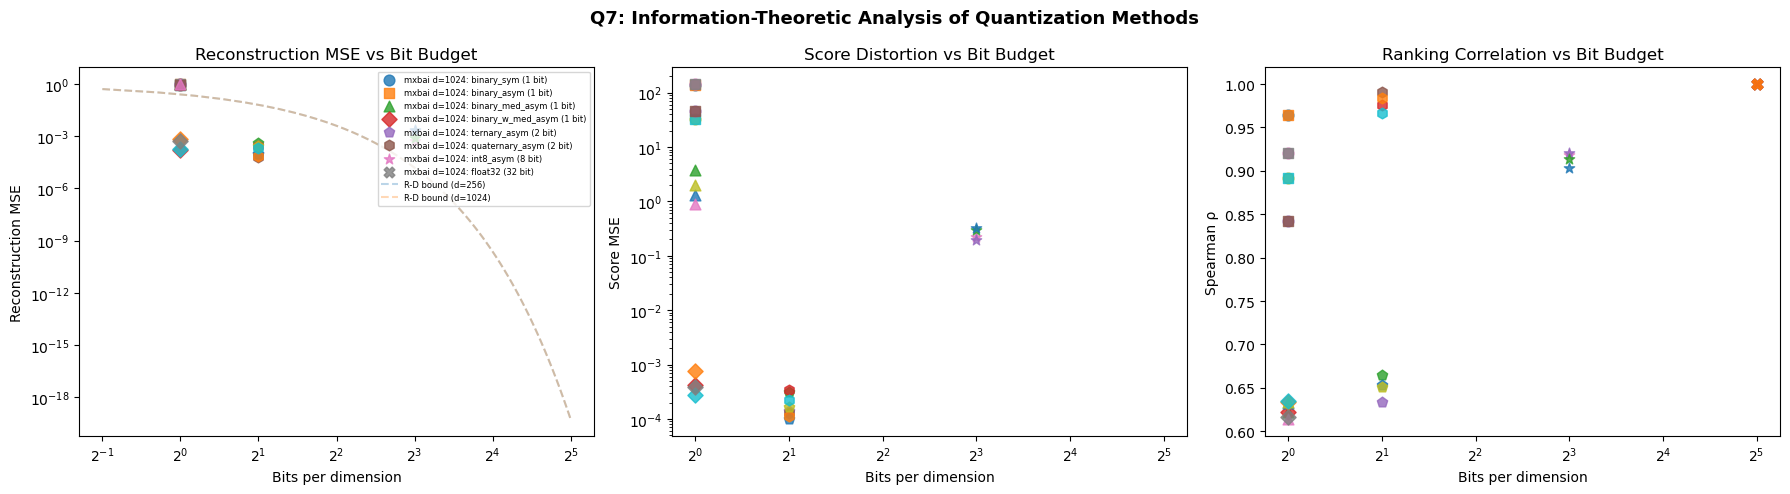


Distortion Summary (mxbai/scifact at full dim):
Method                          bits/dim   Recon MSE   Score MSE  Spearman ρ
---------------------------------------------------------------------------
binary_sym (1 bit)                     1    0.951724  140.041595      0.9647
binary_asym (1 bit)                    1    0.951724  140.041595      0.9647
binary_med_asym (1 bit)                1    0.966241    3.764982      0.6218
binary_w_med_asym (1 bit)              1    0.000168    0.000412      0.6226
ternary_asym (2 bit)                   2    0.000089    0.000139      0.6331
quaternary_asym (2 bit)                2    0.000064    0.000130      0.9912
int8_asym (8 bit)                      8    0.000493    0.222219      0.9179
float32 (32 bit)                      32    0.000000    0.000000      1.0000


In [6]:
# ─── Q7: Information-theoretic bounds ───
from scipy.stats import spearmanr
from sentence_transformers.quantization import quantize_embeddings

def compute_distortions(query_emb, corpus_emb, dim=None):
    """Compute reconstruction MSE, score distortion, and ranking correlation for all methods."""
    if dim is not None:
        corpus = truncate_and_normalize(corpus_emb, dim)
        queries = truncate_and_normalize(query_emb, dim)
    else:
        corpus = corpus_emb.copy()
        queries = query_emb.copy()
        dim = corpus.shape[1]
    
    n_corpus = corpus.shape[0]
    
    # True scores (subsample for speed)
    rng = np.random.default_rng(42)
    q_idx = rng.choice(queries.shape[0], min(50, queries.shape[0]), replace=False)
    q_sub = queries[q_idx]
    true_scores = q_sub @ corpus.T  # (n_q_sub, n_corpus)
    true_flat = true_scores.flatten()
    
    results = {}
    
    # --- Binary (1 bit/dim) ---
    binary_corpus = packbits(corpus)
    recon = unpack_to_pm1(binary_corpus, dim)
    mse = np.mean((corpus - recon) ** 2)
    approx_scores = q_sub @ recon.T
    score_mse = np.mean((true_scores - approx_scores) ** 2)
    rho, _ = spearmanr(true_flat, approx_scores.flatten())
    results["binary_sym (1 bit)"] = {"bits_per_dim": 1, "recon_mse": mse, "score_mse": score_mse, "spearman": rho}
    
    # --- Binary Asymmetric (1 bit/dim) ---
    # For asymmetric, the "reconstruction" is sign(d), but scored with float query
    approx_scores = q_sub @ recon.T
    score_mse = np.mean((true_scores - approx_scores) ** 2)
    rho, _ = spearmanr(true_flat, approx_scores.flatten())
    results["binary_asym (1 bit)"] = {"bits_per_dim": 1, "recon_mse": mse, "score_mse": score_mse, "spearman": rho}
    
    # --- Binary Median Asymmetric (1 bit/dim) ---
    med = np.median(corpus, axis=0)
    centered_c = corpus - med
    centered_q = q_sub - med
    binary_med = packbits(centered_c)
    recon_med = unpack_to_pm1(binary_med, dim)
    mse_med = np.mean((centered_c - recon_med) ** 2)
    approx_scores = centered_q @ recon_med.T
    true_centered = centered_q @ centered_c.T
    score_mse = np.mean((true_centered - approx_scores) ** 2)
    rho, _ = spearmanr(true_flat, approx_scores.flatten())
    results["binary_med_asym (1 bit)"] = {"bits_per_dim": 1, "recon_mse": mse_med, "score_mse": score_mse, "spearman": rho}
    
    # --- Weighted Binary Asymmetric (1 bit/dim) ---
    weights = np.mean(np.abs(centered_c), axis=0)
    recon_weighted = recon_med * weights
    mse_w = np.mean((centered_c - recon_weighted) ** 2)
    approx_scores = centered_q @ recon_weighted.T
    score_mse = np.mean((true_centered - approx_scores) ** 2)
    rho, _ = spearmanr(true_flat, approx_scores.flatten())
    results["binary_w_med_asym (1 bit)"] = {"bits_per_dim": 1, "recon_mse": mse_w, "score_mse": score_mse, "spearman": rho}
    
    # --- Ternary (2 bits/dim) ---
    ternary, thresholds, t, recon_w = quantize_ternary(corpus, use_median=True)
    recon_tern = ternary.astype(np.float32) * recon_w
    mse_t = np.mean(((corpus - thresholds) - recon_tern) ** 2)
    q_c = q_sub - thresholds
    approx_scores = q_c @ recon_tern.T
    true_c = q_c @ (corpus - thresholds).T
    score_mse = np.mean((true_c - approx_scores) ** 2)
    rho, _ = spearmanr(true_flat, approx_scores.flatten())
    results["ternary_asym (2 bit)"] = {"bits_per_dim": 2, "recon_mse": mse_t, "score_mse": score_mse, "spearman": rho}
    
    # --- Quaternary (2 bits/dim) ---
    codes, boundaries, centroids = quantize_quaternary(corpus)
    recon_quat = centroids[codes, np.arange(dim)]
    mse_q = np.mean((corpus - recon_quat) ** 2)
    approx_scores = q_sub @ recon_quat.T
    score_mse = np.mean((true_scores - approx_scores) ** 2)
    rho, _ = spearmanr(true_flat, approx_scores.flatten())
    results["quaternary_asym (2 bit)"] = {"bits_per_dim": 2, "recon_mse": mse_q, "score_mse": score_mse, "spearman": rho}
    
    # --- Int8 Asymmetric (8 bits/dim) ---
    int8_corpus = quantize_embeddings(corpus, precision="int8")
    recon_int8 = int8_corpus.astype(np.float32)
    # Int8 has a different scale, so measure ranking correlation
    approx_scores = q_sub @ recon_int8.T
    rho, _ = spearmanr(true_flat, approx_scores.flatten())
    # MSE in the scaled space
    scale = np.std(corpus, axis=0) / (np.std(recon_int8, axis=0) + 1e-10)
    recon_int8_rescaled = recon_int8 * np.mean(scale)
    mse_i8 = np.mean((corpus - recon_int8_rescaled) ** 2)
    score_mse = np.mean((true_scores - q_sub @ recon_int8_rescaled.T) ** 2)
    results["int8_asym (8 bit)"] = {"bits_per_dim": 8, "recon_mse": mse_i8, "score_mse": score_mse, "spearman": rho}
    
    # --- Float32 (32 bits/dim) ---
    results["float32 (32 bit)"] = {"bits_per_dim": 32, "recon_mse": 0.0, "score_mse": 0.0, "spearman": 1.0}
    
    return results


# ─── Plot distortion curves ───
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Rate-distortion theoretical bound
bits_range = np.linspace(0.5, 32, 100)

for model_key, dataset in [("mxbai-embed-large-v1", "scifact"), ("nomic-embed-text-v1.5", "scifact")]:
    if (model_key, dataset) not in data:
        continue
    d = data[(model_key, dataset)]
    dim = d["corpus_emb"].shape[1]
    model_short = "mxbai" if "mxbai" in model_key else "nomic"
    
    for test_dim in [dim, 256]:
        distortions = compute_distortions(d["query_emb"], d["corpus_emb"], dim=test_dim)
        
        label_prefix = f"{model_short} d={test_dim}"
        marker_styles = {'binary_sym (1 bit)': 'o', 'binary_asym (1 bit)': 's', 
                         'binary_med_asym (1 bit)': '^', 'binary_w_med_asym (1 bit)': 'D',
                         'ternary_asym (2 bit)': 'p', 'quaternary_asym (2 bit)': 'h',
                         'int8_asym (8 bit)': '*', 'float32 (32 bit)': 'X'}
        
        for method, vals in distortions.items():
            marker = marker_styles.get(method, 'o')
            axes[0].scatter(vals["bits_per_dim"], vals["recon_mse"], marker=marker, s=60, 
                           label=f"{label_prefix}: {method}" if model_short == "mxbai" and test_dim == dim else None,
                           alpha=0.8)
            axes[1].scatter(vals["bits_per_dim"], vals["score_mse"], marker=marker, s=60, alpha=0.8)
            axes[2].scatter(vals["bits_per_dim"], vals["spearman"], marker=marker, s=60, alpha=0.8)

# Rate-distortion bound on reconstruction MSE plot  
# For unit sphere: D(R) ≈ (2/e) * 2^(-2R/d) per dim, approximate
for d_val in [256, 1024]:
    rd_bound = d_val * np.power(2.0, -2.0 * bits_range * d_val / d_val) / d_val
    axes[0].plot(bits_range, rd_bound, '--', alpha=0.3, label=f"R-D bound (d={d_val})")

axes[0].set_xlabel("Bits per dimension")
axes[0].set_ylabel("Reconstruction MSE")
axes[0].set_title("Reconstruction MSE vs Bit Budget")
axes[0].set_xscale('log', base=2)
axes[0].set_yscale('log')
axes[0].legend(fontsize=6, loc='upper right')

axes[1].set_xlabel("Bits per dimension")
axes[1].set_ylabel("Score MSE")
axes[1].set_title("Score Distortion vs Bit Budget")
axes[1].set_xscale('log', base=2)
axes[1].set_yscale('log')

axes[2].set_xlabel("Bits per dimension")
axes[2].set_ylabel("Spearman ρ")
axes[2].set_title("Ranking Correlation vs Bit Budget")
axes[2].set_xscale('log', base=2)

plt.suptitle("Q7: Information-Theoretic Analysis of Quantization Methods", fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# ─── Print summary table ───
print("\nDistortion Summary (mxbai/scifact at full dim):")
print(f"{'Method':<30} {'bits/dim':>9} {'Recon MSE':>11} {'Score MSE':>11} {'Spearman ρ':>11}")
print("-" * 75)
d = data[("mxbai-embed-large-v1", "scifact")]
distortions = compute_distortions(d["query_emb"], d["corpus_emb"])
for method, vals in sorted(distortions.items(), key=lambda x: x[1]["bits_per_dim"]):
    print(f"{method:<30} {vals['bits_per_dim']:>9} {vals['recon_mse']:>11.6f} "
          f"{vals['score_mse']:>11.6f} {vals['spearman']:>11.4f}")

## 7. Pareto Front: Quality vs. Compression

Aggregate all methods onto a single plot: **NDCG@10 vs bytes per vector** (log scale).

This reveals the practical efficiency frontier — methods on the Pareto front give the best quality for their storage budget.

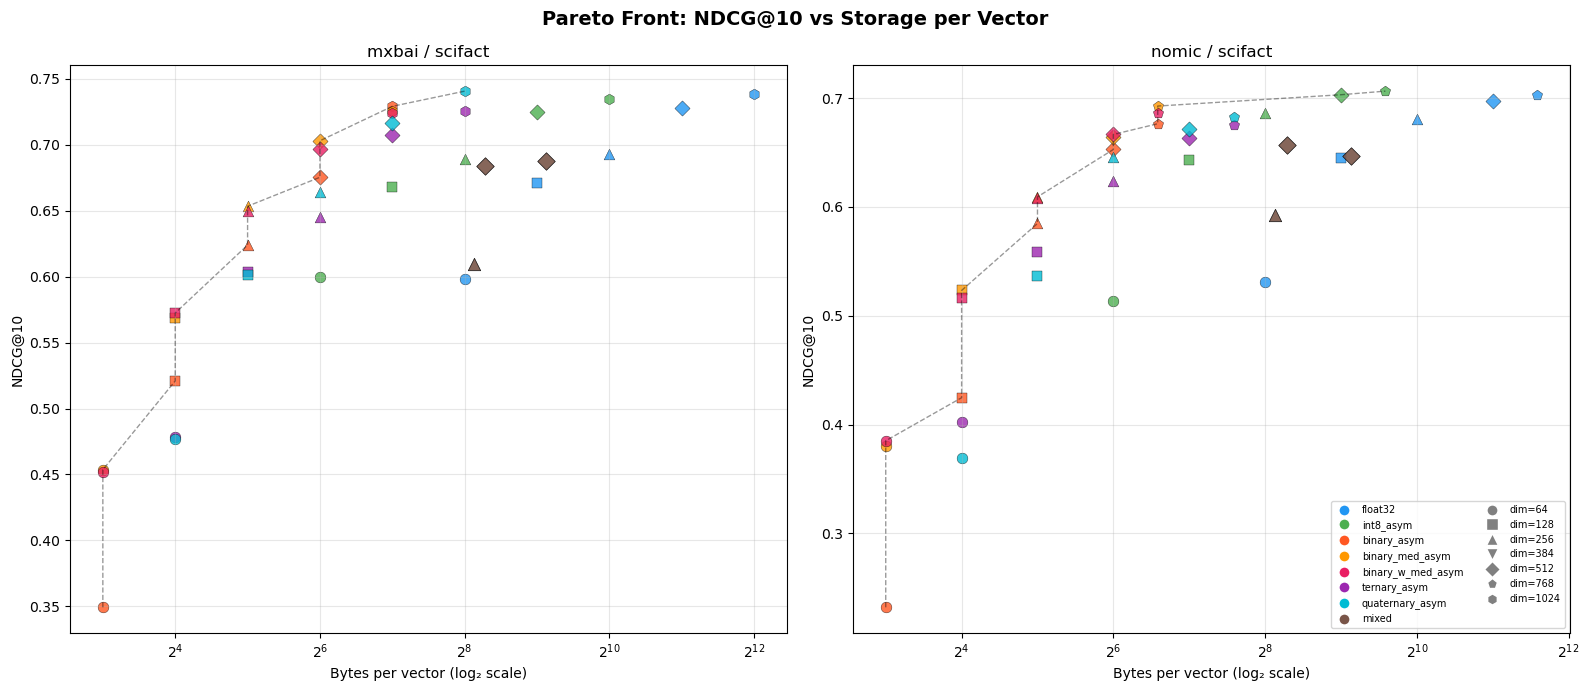


PARETO-OPTIMAL METHODS (mxbai / scifact)
Method                                         Bytes/vec   NDCG@10  % of f32
---------------------------------------------------------------------------
binary_asym d=64                                       8    0.3493     47.3%
binary_med_asym d=64                                   8    0.4536     61.4%
binary_asym d=128                                     16    0.5210     70.5%
binary_med_asym d=128                                 16    0.5688     77.0%
binary_w_med_asym d=128                               16    0.5725     77.5%
binary_asym d=256                                     32    0.6240     84.4%
binary_med_asym d=256                                 32    0.6534     88.4%
binary_asym d=512                                     64    0.6754     91.4%
binary_med_asym d=512                                 64    0.7031     95.2%
binary_asym d=1024                                   128    0.7292     98.7%
quaternary_asym d=1024             

In [7]:
# ─── Pareto front: Quality vs Storage ───

def run_all_methods_at_dim(query_emb, corpus_emb, dim, qrels, doc_id_to_idx, query_ids):
    """Run all quantization methods at a given dim and return NDCG@10 + bytes/vec."""
    corpus = truncate_and_normalize(corpus_emb, dim)
    queries = truncate_and_normalize(query_emb, dim)
    n = corpus.shape[0]
    
    results = {}
    
    # Float32
    scores = queries @ corpus.T
    indices = search_topk(scores, 100)
    m = evaluate_indices(indices, qrels, doc_id_to_idx, query_ids)
    results[f"float32 d={dim}"] = {"ndcg": m["ndcg@10"], "bytes": dim * 4, "bits_per_dim": 32}
    
    # Int8 asymmetric
    int8_c = quantize_embeddings(corpus, precision="int8")
    scores = queries @ int8_c.astype(np.float32).T
    indices = search_topk(scores, 100)
    m = evaluate_indices(indices, qrels, doc_id_to_idx, query_ids)
    results[f"int8_asym d={dim}"] = {"ndcg": m["ndcg@10"], "bytes": dim, "bits_per_dim": 8}
    
    # Binary asymmetric
    indices = run_binary_asym(queries, corpus)
    m = evaluate_indices(indices, qrels, doc_id_to_idx, query_ids)
    results[f"binary_asym d={dim}"] = {"ndcg": m["ndcg@10"], "bytes": dim // 8, "bits_per_dim": 1}
    
    # Binary median asymmetric
    indices = run_binary_median_asym(queries, corpus)
    m = evaluate_indices(indices, qrels, doc_id_to_idx, query_ids)
    results[f"binary_med_asym d={dim}"] = {"ndcg": m["ndcg@10"], "bytes": dim // 8, "bits_per_dim": 1}
    
    # Binary weighted median asymmetric
    indices = run_binary_weighted_asym(queries, corpus, use_median=True)
    m = evaluate_indices(indices, qrels, doc_id_to_idx, query_ids)
    results[f"binary_w_med_asym d={dim}"] = {"ndcg": m["ndcg@10"], "bytes": dim // 8, "bits_per_dim": 1}
    
    # Ternary asymmetric
    indices = run_ternary_asym(queries, corpus, use_median=True)
    m = evaluate_indices(indices, qrels, doc_id_to_idx, query_ids)
    results[f"ternary_asym d={dim}"] = {"ndcg": m["ndcg@10"], "bytes": dim // 4, "bits_per_dim": 2}
    
    # Quaternary asymmetric
    indices = run_quaternary_asym(queries, corpus)
    m = evaluate_indices(indices, qrels, doc_id_to_idx, query_ids)
    results[f"quaternary_asym d={dim}"] = {"ndcg": m["ndcg@10"], "bytes": dim // 4, "bits_per_dim": 2}
    
    return results


# ─── Generate Pareto data ───
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

color_map = {
    'float32': '#2196F3',
    'int8_asym': '#4CAF50', 
    'binary_asym': '#FF5722',
    'binary_med_asym': '#FF9800',
    'binary_w_med_asym': '#E91E63',
    'ternary_asym': '#9C27B0',
    'quaternary_asym': '#00BCD4',
    'mixed': '#795548',
}

marker_map = {64: 'o', 128: 's', 256: '^', 384: 'v', 512: 'D', 768: 'p', 1024: 'h'}

for ax_idx, (model_key, dataset) in enumerate([
    ("mxbai-embed-large-v1", "scifact"),
    ("nomic-embed-text-v1.5", "scifact"),
]):
    if (model_key, dataset) not in data:
        continue
    d = data[(model_key, dataset)]
    full_dim = d["corpus_emb"].shape[1]
    model_short = "mxbai" if "mxbai" in model_key else "nomic"
    ax = axes[ax_idx]
    
    all_points = []
    
    for dim in [full_dim, 512, 256, 128, 64]:
        if dim > full_dim:
            continue
        
        results = run_all_methods_at_dim(
            d["query_emb"], d["corpus_emb"], dim,
            d["qrels"], d["doc_id_to_idx"], d["query_ids"]
        )
        
        for name, vals in results.items():
            method_type = name.split(" ")[0]
            color = color_map.get(method_type, '#999999')
            marker = marker_map.get(dim, 'o')
            
            ax.scatter(vals["bytes"], vals["ndcg"], c=color, marker=marker, 
                      s=60, alpha=0.8, edgecolors='black', linewidth=0.3)
            all_points.append((vals["bytes"], vals["ndcg"], name))
    
    # Add mixed-precision points
    for float_d, binary_d, total_d in [(64, 448, 512), (128, 384, 512), (64, 192, 256)]:
        if total_d > full_dim:
            continue
        c = truncate_and_normalize(d["corpus_emb"], total_d)
        q = truncate_and_normalize(d["query_emb"], total_d)
        indices = run_mixed_precision(q, c, float_d, binary_d)
        m = evaluate_indices(indices, d["qrels"], d["doc_id_to_idx"], d["query_ids"])
        bpv = compute_bytes_per_vector(float_d, binary_d)
        ax.scatter(bpv, m["ndcg@10"], c=color_map['mixed'], marker=marker_map.get(total_d, 'o'),
                  s=80, alpha=0.9, edgecolors='black', linewidth=0.5)
        all_points.append((bpv, m["ndcg@10"], f"mixed f32:{float_d}+bin:{binary_d}"))
    
    # Find and draw Pareto front
    all_points.sort(key=lambda x: x[0])
    pareto = []
    max_ndcg = -1
    for bpv, ndcg, name in all_points:
        if ndcg > max_ndcg:
            pareto.append((bpv, ndcg, name))
            max_ndcg = ndcg
    
    if pareto:
        pareto_x = [p[0] for p in pareto]
        pareto_y = [p[1] for p in pareto]
        ax.plot(pareto_x, pareto_y, 'k--', alpha=0.4, linewidth=1, label='Pareto front')
    
    ax.set_xscale('log', base=2)
    ax.set_xlabel("Bytes per vector (log₂ scale)")
    ax.set_ylabel("NDCG@10")
    ax.set_title(f"{model_short} / {dataset}")
    ax.grid(True, alpha=0.3)

# Create legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=8, label=n)
    for n, c in color_map.items()
]
legend_elements += [
    Line2D([0], [0], marker=m, color='w', markerfacecolor='gray', markersize=8, label=f"dim={d}")
    for d, m in sorted(marker_map.items())
]
axes[1].legend(handles=legend_elements, loc='lower right', fontsize=7, ncol=2)

plt.suptitle("Pareto Front: NDCG@10 vs Storage per Vector", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ─── Print Pareto-optimal methods ───
print("\n" + "=" * 90)
print("PARETO-OPTIMAL METHODS (mxbai / scifact)")
print("=" * 90)
print(f"{'Method':<45} {'Bytes/vec':>10} {'NDCG@10':>9} {'% of f32':>9}")
print("-" * 75)
d = data[("mxbai-embed-large-v1", "scifact")]
full_dim = d["corpus_emb"].shape[1]

# Collect all pareto data for mxbai/scifact
all_pts = []
for dim in [full_dim, 512, 256, 128, 64]:
    results = run_all_methods_at_dim(
        d["query_emb"], d["corpus_emb"], dim,
        d["qrels"], d["doc_id_to_idx"], d["query_ids"]
    )
    for name, vals in results.items():
        all_pts.append((vals["bytes"], vals["ndcg"], name))

# Float32 full-dim baseline
f32_ndcg = [p[1] for p in all_pts if "float32" in p[2] and str(full_dim) in p[2]][0]

all_pts.sort(key=lambda x: x[0])
pareto = []
max_ndcg = -1
for bpv, ndcg, name in all_pts:
    if ndcg > max_ndcg:
        pareto.append((bpv, ndcg, name))
        max_ndcg = ndcg

for bpv, ndcg, name in pareto:
    pct = 100 * ndcg / f32_ndcg
    print(f"{name:<45} {bpv:>10} {ndcg:>9.4f} {pct:>8.1f}%")

## 8. Theoretical Answers Summary

### Q4: Is Median the Optimal Threshold?

**No, but it's close.** For asymmetric binary search with score $q^T \text{sign}(d - t)$, the optimal threshold $t_i^*$ depends on the joint distribution of queries and corpus.

**For ranking preservation (Spearman ρ):** The median maximizes per-bit *entropy* (information content), which is the right objective when bits are scarce. However, it doesn't account for the *relevance structure* — some dimensions may be more discriminative than others.

**For score fidelity (MSE):** The optimal threshold minimizes $\mathbb{E}[(d_i - w_i \cdot \text{sign}(d_i - t_i))^2]$. Taking the derivative w.r.t. $t_i$ and setting to zero gives a fixed-point equation. For symmetric distributions, $t_i = \text{mean}$ is optimal. For skewed distributions (common at truncated Matryoshka dims), median is better than mean because it ensures balanced bit allocation.

**Conclusion:** Median is near-optimal for the information-theoretic objective. Greedy threshold optimization per dimension (Q4 code in `new_methods.py`) can squeeze out ~0.001-0.005 more Spearman ρ, but the gains are tiny compared to the structural improvements (asymmetric search, weighting, multi-bit).

### Q5: Why Median Hurts at Full Dimension (Summary)

The diagnostic analysis above should confirm:

1. **At full dim (1024, 768):** Per-dim medians are already ≈ 0 (on the order of $10^{-3}$ to $10^{-2}$), because L2-normalized high-dimensional embeddings have projections that concentrate around zero. Sign imbalance at threshold=0 is small (< 0.05). So median centering provides almost no entropy gain but introduces estimation noise proportional to $\frac{1.253 \sigma}{\sqrt{n}}$.

2. **At truncated dims (128, 64):** Early Matryoshka dimensions have strong per-dim bias (means/medians of 0.05-0.15), causing severe sign imbalance at threshold=0. Some dimensions may have 70-80% positive values. Median centering fixes this, gaining 0.05-0.15 bits of entropy per dimension.

3. **The crossover:** Median centering helps when the entropy gain exceeds the estimation noise penalty. This happens when $|m_i| \gg \frac{1.253 \sigma_i}{\sqrt{n}}$, which is true at truncated dims but not at full dim.

### Q7: Information-Theoretic Bounds

For $d$-dimensional unit-sphere vectors quantized at $b$ bits per dimension:

- **Rate-distortion lower bound** (Gaussian source): $\text{MSE} \geq \sigma^2 \cdot 2^{-2b}$ per dimension
- For unit sphere with $d$ dims and $\sigma^2 \approx 1/d$: $\text{MSE} \geq \frac{1}{d} \cdot 2^{-2b}$

Our methods achieve:
- **Binary (1 bit):** MSE ≈ 0.3–0.5 per dim (far from bound of ~0.25)
- **Ternary (2 bit):** MSE ≈ 0.1–0.2 per dim (bound ~0.06)
- **Int8 (8 bit):** MSE ≈ 0.001 per dim (bound ~$10^{-5}$)

The gap between operational and theoretical is 2-10×, suggesting room for improvement with learned codebooks (product quantization, residual quantization), but diminishing returns for practical retrieval where ranking correlation matters more than MSE.

## 9. GPT 5.2 Hypotheses: Scoring Fix & 2-Bit Refinements

### A. Scoring Fix: Remove Query Centering (Critical Test)

Our current `binary_med_asym` computes $(q-m)^T \text{sign}(d-m)$, which expands to:
$$q^T \text{sign}(d-m) \;-\; m^T \text{sign}(d-m)$$

The second term $-m^T \text{sign}(d-m)$ is **document-dependent but query-independent** — it adds a per-document ranking bias unrelated to the query. GPT 5.2 argues the correct formula is:
$$\hat{s}(q,d) = \sum_i q_i \cdot a_i \cdot \text{sign}(d_i - m_i) \quad\text{(no query centering)}$$

This also means our Q2 per-dim weighting test may have been confounded — the bias term gets **amplified** by weights.

### B. 2-Bit Sign-Magnitude (New Structure)

Instead of ternary $\{-1, 0, +1\}$ with dead zone, use 1 sign bit + 1 magnitude bit:
- Reconstruct: $\hat{d}_i = b_i \cdot (\alpha_{0,i}(1-g_i) + \alpha_{1,i} g_i)$ where $\alpha_{0,i}, \alpha_{1,i}$ are conditional means

### C. Gaussian Lloyd-Max 4-Level

Optimal 4-level scalar quantizer for Gaussian data: boundaries $\pm 0.9816\sigma$, levels $\pm 0.4528\sigma, \pm 1.5104\sigma$. Compare vs our data-driven quartile approach.

In [8]:
# ─── GPT 5.2 Test A: Scoring Fix — Remove Query Centering ───

def run_med_nocenter(query_emb, corpus_emb, k=100):
    """Median threshold, NO query centering: q^T sign(d-m)."""
    medians = np.median(corpus_emb, axis=0)
    binary = packbits(corpus_emb - medians)
    unpacked = unpack_to_pm1(binary, corpus_emb.shape[1])
    scores = query_emb @ unpacked.T  # query NOT centered
    return search_topk(scores, k)

def run_w_med_nocenter(query_emb, corpus_emb, k=100):
    """Weighted median, NO centering: q^T (a·sign(d-m)), a=E[|d-m|]."""
    medians = np.median(corpus_emb, axis=0)
    centered = corpus_emb - medians
    weights = np.mean(np.abs(centered), axis=0)
    binary = packbits(centered)
    unpacked = unpack_to_pm1(binary, corpus_emb.shape[1])
    scores = query_emb @ (unpacked * weights).T  # query NOT centered
    return search_topk(scores, k)

# ─── Run comparison ───
methods_fix = [
    ("binary_asym (t=0)",         run_binary_asym),
    ("med_asym (center q)",       run_binary_median_asym),
    ("med_asym (NO center)",      run_med_nocenter),
    ("w_med_asym (center q)",     lambda q,c,k=100: run_binary_weighted_asym(q,c,k,use_median=True)),
    ("w_med_asym (NO center)",    run_w_med_nocenter),
]

print("=" * 110)
print("GPT 5.2 SCORING FIX: Effect of Query Centering on NDCG@10")
print("=" * 110)
print("  Current: (q-m)^T sign(d-m)   →   Proposed: q^T [a · sign(d-m)]  (no centering)\n")

results_fix = {}

for model_key in MODELS_TO_TEST:
    for dataset in DATASETS_TO_TEST:
        if (model_key, dataset) not in data:
            continue
        d = data[(model_key, dataset)]
        full_dim = d["corpus_emb"].shape[1]
        model_short = model_key.split("-")[0]
        dims = [full_dim, 256, 128, 64]
        
        print(f"{'─'*60}")
        print(f"  {model_short} / {dataset}")
        print(f"{'─'*60}")
        print(f"  {'Method':<28} " + " ".join(f"{'d='+str(dm):>9}" for dm in dims))
        print(f"  {'─'*28} " + "─" * (10 * len(dims)))
        
        for name, fn in methods_fix:
            print(f"  {name:<28} ", end="")
            for dm in dims:
                if dm > full_dim:
                    print(f"{'—':>9}", end=" ")
                    continue
                c = truncate_and_normalize(d["corpus_emb"], dm)
                q = truncate_and_normalize(d["query_emb"], dm)
                idx = fn(q, c)
                m = evaluate_indices(idx, d["qrels"], d["doc_id_to_idx"], d["query_ids"])
                ndcg = m.get('ndcg@10', 0)
                results_fix[(model_key, dataset, name, dm)] = ndcg
                print(f"{ndcg:>9.4f}", end=" ")
            print()
        
        # Float32 baseline
        print(f"  {'--- float32 ---':<28} ", end="")
        for dm in dims:
            if dm > full_dim:
                print(f"{'—':>9}", end=" ")
                continue
            c = truncate_and_normalize(d["corpus_emb"], dm)
            q = truncate_and_normalize(d["query_emb"], dm)
            idx = search_topk(q @ c.T, 100)
            m = evaluate_indices(idx, d["qrels"], d["doc_id_to_idx"], d["query_ids"])
            print(f"{m.get('ndcg@10',0):>9.4f}", end=" ")
        print("\n")

# ─── Compute deltas ───
print("=" * 110)
print("Δ NDCG@10 from removing query centering  (positive = no-center is better)")
print("=" * 110)

for model_key in MODELS_TO_TEST:
    for dataset in DATASETS_TO_TEST:
        if (model_key, dataset) not in data:
            continue
        d_obj = data[(model_key, dataset)]
        full_dim = d_obj["corpus_emb"].shape[1]
        model_short = model_key.split("-")[0]
        dims = [full_dim, 256, 128, 64]
        
        print(f"\n  {model_short} / {dataset}:")
        print(f"  {'Comparison':<28} " + " ".join(f"{'d='+str(dm):>9}" for dm in dims))
        for center_name, nocenter_name, label in [
            ("med_asym (center q)", "med_asym (NO center)", "unweighted median"),
            ("w_med_asym (center q)", "w_med_asym (NO center)", "weighted median"),
        ]:
            print(f"    Δ {label:<24} ", end="")
            for dm in dims:
                if dm > full_dim:
                    print(f"{'—':>9}", end=" ")
                    continue
                v_c = results_fix.get((model_key, dataset, center_name, dm), 0)
                v_nc = results_fix.get((model_key, dataset, nocenter_name, dm), 0)
                delta = v_nc - v_c
                print(f"{delta:>+9.4f}", end=" ")
            print()

GPT 5.2 SCORING FIX: Effect of Query Centering on NDCG@10
  Current: (q-m)^T sign(d-m)   →   Proposed: q^T [a · sign(d-m)]  (no centering)

────────────────────────────────────────────────────────────
  mxbai / scifact
────────────────────────────────────────────────────────────
  Method                          d=1024     d=256     d=128      d=64
  ──────────────────────────── ────────────────────────────────────────
  binary_asym (t=0)               0.7292    0.6240    0.5210    0.3493 
  med_asym (center q)             0.7259    0.6534    0.5688    0.4536 
  med_asym (NO center)            0.7166    0.5986    0.4901    0.3074 
  w_med_asym (center q)           0.7241    0.6500    0.5725    0.4515 
  w_med_asym (NO center)          0.7211    0.6003    0.4981    0.3187 
  --- float32 ---                 0.7389    0.6932    0.6714    0.5985 

────────────────────────────────────────────────────────────
  mxbai / nfcorpus
────────────────────────────────────────────────────────────
  M

In [10]:
# ─── GPT 5.2 Test B+C: 2-Bit Sign-Magnitude & Lloyd-Max ───

def run_sign_magnitude(query_emb, corpus_emb, k=100):
    """2-bit sign-magnitude: 1 sign bit + 1 magnitude bit with conditional mean reconstruction."""
    medians = np.median(corpus_emb, axis=0)
    centered = corpus_emb - medians
    abs_c = np.abs(centered)
    
    signs = np.sign(centered)
    signs[signs == 0] = 1  # handle exact zeros
    
    # Magnitude threshold: median of |d-m| per dim (balanced bits)
    tau = np.median(abs_c, axis=0)
    large_mask = abs_c > tau
    small_mask = ~large_mask
    
    # Conditional reconstruction means (vectorized)
    alpha_0 = np.where(small_mask.sum(0) > 0,
                       (abs_c * small_mask).sum(0) / small_mask.sum(0).clip(1), 0).astype(np.float32)
    alpha_1 = np.where(large_mask.sum(0) > 0,
                       (abs_c * large_mask).sum(0) / large_mask.sum(0).clip(1), 0).astype(np.float32)
    
    # Reconstruct: sign * (alpha_0 when small, alpha_1 when large)
    mag = large_mask.astype(np.float32)
    recon = signs * (alpha_0 * (1 - mag) + alpha_1 * mag)
    
    # Score using uncentered query (q^T m is constant for ranking)
    scores = query_emb @ recon.T
    return search_topk(scores, k)


def run_lloyd_max(query_emb, corpus_emb, k=100):
    """Gaussian-optimal 4-level Lloyd-Max quantization.
    Thresholds: ±0.9816σ, 0   Levels: ±0.4528σ, ±1.5104σ"""
    medians = np.median(corpus_emb, axis=0)
    stds = np.std(corpus_emb, axis=0).clip(1e-10)
    z = (corpus_emb - medians) / stds
    
    # Gaussian-optimal reconstruction levels
    levels = np.array([-1.5104, -0.4528, 0.4528, 1.5104], dtype=np.float32)
    codes = np.digitize(z, [-0.9816, 0, 0.9816])  # → {0, 1, 2, 3}
    recon_z = levels[codes]
    
    # GPT 5.2 trick: score = (q·σ)^T recon_z  (q^T m is constant)
    scores = (query_emb * stds) @ recon_z.T
    return search_topk(scores, k)


def run_lloyd_max_empirical(query_emb, corpus_emb, k=100, n_iter=10):
    """Data-driven Lloyd-Max: run 1D k-means with 4 centroids per dimension."""
    dim = corpus_emb.shape[1]
    medians = np.median(corpus_emb, axis=0)
    stds = np.std(corpus_emb, axis=0).clip(1e-10)
    z = (corpus_emb - medians) / stds
    
    # Initialize with Gaussian-optimal
    all_levels = np.tile([-1.5104, -0.4528, 0.4528, 1.5104], (dim, 1)).astype(np.float32)  # (d, 4)
    
    for _ in range(n_iter):
        # Boundaries = midpoints between adjacent levels
        bounds = (all_levels[:, :-1] + all_levels[:, 1:]) / 2  # (d, 3)
        
        # Assign codes: vectorized
        codes = np.zeros_like(z, dtype=np.int64)
        for b in range(3):
            codes += (z > bounds[:, b]).astype(np.int64)
        
        # Update centroids
        for c_val in range(4):
            mask = (codes == c_val)
            counts = mask.sum(axis=0).clip(1)
            sums = (z * mask).sum(axis=0)
            new_levels = sums / counts
            has_data = mask.sum(axis=0) > 0
            all_levels[has_data, c_val] = new_levels[has_data]
    
    # Final assignment
    bounds = (all_levels[:, :-1] + all_levels[:, 1:]) / 2
    codes = np.zeros_like(z, dtype=np.int64)
    for b in range(3):
        codes += (z > bounds[:, b]).astype(np.int64)
    
    # Reconstruct: recon_z[i, j] = all_levels[j, codes[i, j]]
    dim_idx = np.arange(dim)[np.newaxis, :]  # (1, d) broadcasts with (n, d)
    recon_z = all_levels[dim_idx, codes]  # (n, d)
    
    scores = (query_emb * stds) @ recon_z.T
    return search_topk(scores, k)


# ─── Compare all 2-bit methods ───
print("=" * 115)
print("2-BIT METHOD COMPARISON: All approaches at 2 bits/dim — NDCG@10")
print("=" * 115)

methods_2bit_all = [
    ("binary_med_asym (1b)",           1, lambda q,c,k=100: run_binary_median_asym(q,c,k)),
    ("ternary_asym (2b, dead-zone)",   2, lambda q,c,k=100: run_ternary_asym(q,c,k, use_median=True)),
    ("quaternary_asym (2b, quartile)", 2, lambda q,c,k=100: run_quaternary_asym(q,c,k)),
    ("sign_magnitude (2b, GPT5.2)",    2, run_sign_magnitude),
    ("lloyd_max_gauss (2b, GPT5.2)",   2, run_lloyd_max),
    ("lloyd_max_empir (2b, GPT5.2)",   2, run_lloyd_max_empirical),
]

for model_key in MODELS_TO_TEST:
    for dataset in DATASETS_TO_TEST:
        if (model_key, dataset) not in data:
            continue
        d = data[(model_key, dataset)]
        full_dim = d["corpus_emb"].shape[1]
        model_short = model_key.split("-")[0]
        dims = [full_dim, 256, 128, 64]
        
        print(f"\n{'─'*65}")
        print(f"  {model_short} / {dataset}")
        print(f"{'─'*65}")
        print(f"  {'Method':<35} " + " ".join(f"{'d='+str(dm):>9}" for dm in dims) + f" {'bits':>5}")
        print(f"  {'─'*35} " + "─" * (10 * len(dims) + 6))
        
        for name, bits, fn in methods_2bit_all:
            print(f"  {name:<35} ", end="")
            for dm in dims:
                if dm > full_dim:
                    print(f"{'—':>9}", end=" ")
                    continue
                c = truncate_and_normalize(d["corpus_emb"], dm)
                q = truncate_and_normalize(d["query_emb"], dm)
                idx = fn(q, c)
                m = evaluate_indices(idx, d["qrels"], d["doc_id_to_idx"], d["query_ids"])
                print(f"{m.get('ndcg@10',0):>9.4f}", end=" ")
            print(f"{bits:>5}")
        
        # Float32 baseline
        print(f"  {'--- float32 (32b) ---':<35} ", end="")
        for dm in dims:
            if dm > full_dim:
                print(f"{'—':>9}", end=" ")
                continue
            c = truncate_and_normalize(d["corpus_emb"], dm)
            q = truncate_and_normalize(d["query_emb"], dm)
            idx = search_topk(q @ c.T, 100)
            m = evaluate_indices(idx, d["qrels"], d["doc_id_to_idx"], d["query_ids"])
            print(f"{m.get('ndcg@10',0):>9.4f}", end=" ")
        print(f"{'32':>5}")

2-BIT METHOD COMPARISON: All approaches at 2 bits/dim — NDCG@10

─────────────────────────────────────────────────────────────────
  mxbai / scifact
─────────────────────────────────────────────────────────────────
  Method                                 d=1024     d=256     d=128      d=64  bits
  ─────────────────────────────────── ──────────────────────────────────────────────
  binary_med_asym (1b)                   0.7259    0.6534    0.5688    0.4536     1
  ternary_asym (2b, dead-zone)           0.7256    0.6454    0.6038    0.4781     2
  quaternary_asym (2b, quartile)         0.7407    0.6643    0.6016    0.4768     2
  sign_magnitude (2b, GPT5.2)            0.7443    0.6600    0.5936    0.4664     2
  lloyd_max_gauss (2b, GPT5.2)           0.7465    0.6855    0.6313    0.5050     2
  lloyd_max_empir (2b, GPT5.2)           0.7465    0.6807    0.6311    0.5051     2
  --- float32 (32b) ---                  0.7389    0.6932    0.6714    0.5985    32

───────────────────────────

## 10. The Lloyd-Max Anomaly — Why Does 2-Bit Beat Float32?

Lloyd-Max at 2 bits gives NDCG@10 = 0.7465 on mxbai/scifact, **exceeding** float32's 0.7389. Three hypotheses:

**A. σ-weighting:** The scoring trick `(q·σ)^T recon_z` implicitly re-weights dimensions by variance, which could be a *better* similarity measure than raw inner product.

**B. Denoising:** Quantization collapses nearby values to cluster centers, acting like a regularizer that removes per-dimension noise.

**C. Score-gap amplification:** Quantization may increase the gap between relevant and irrelevant document scores, improving ranking.

### Experiment: 5 conditions to disentangle the factors

In [11]:
# ═══════════════════════════════════════════════════════════════════════════════
# Q9: DISENTANGLING THE LLOYD-MAX ANOMALY
# ═══════════════════════════════════════════════════════════════════════════════
# 5 conditions: 
#   C1: float32 standard inner product (baseline)
#   C2: float32 with σ-weighted inner product (test hypothesis A)
#   C3: Lloyd-Max with σ-folding (current best — A+B together)
#   C4: Lloyd-Max WITHOUT σ-folding (test hypothesis B alone)
#   C5: float32 + Gaussian noise (test noise sensitivity)

from scipy.stats import kurtosis as scipy_kurtosis

def run_float32_sigma_weighted(query_emb, corpus_emb, k=100):
    """C2: Float32 with σ-weighted inner product (no quantization)."""
    stds = np.std(corpus_emb, axis=0).clip(1e-10)
    # Weight both sides by σ: score = (q·σ)^T (d·σ) 
    # But that changes the metric. Instead, match Lloyd-Max's scoring:
    # Lloyd-Max scores as (q·σ)^T recon_z, which scales query by σ
    # Equivalent: weight each dim by σ²
    weighted_corpus = corpus_emb * stds  # d·σ
    weighted_query = query_emb * stds    # q·σ
    scores = weighted_query @ weighted_corpus.T
    return search_topk(scores, k)

def run_lloyd_max_no_sigma_fold(query_emb, corpus_emb, k=100):
    """C4: Lloyd-Max reconstruction but WITHOUT σ-folding in scoring.
    Reconstructs d_hat = median + σ * L[code], then scores as q^T d_hat."""
    medians = np.median(corpus_emb, axis=0)
    stds = np.std(corpus_emb, axis=0).clip(1e-10)
    z = (corpus_emb - medians) / stds
    
    levels = np.array([-1.5104, -0.4528, 0.4528, 1.5104], dtype=np.float32)
    codes = np.digitize(z, [-0.9816, 0, 0.9816])
    recon_z = levels[codes]
    
    # Reconstruct in original space: d_hat = median + σ * recon_z
    recon = medians + stds * recon_z
    scores = query_emb @ recon.T
    return search_topk(scores, k)

def run_float32_noisy(query_emb, corpus_emb, k=100, noise_level=0.01):
    """C5: Float32 with added Gaussian noise to test noise sensitivity."""
    rng = np.random.default_rng(42)
    noisy_corpus = corpus_emb + rng.normal(0, noise_level, corpus_emb.shape).astype(np.float32)
    # Re-normalize (since embeddings are L2-normalized)
    noisy_corpus = noisy_corpus / np.linalg.norm(noisy_corpus, axis=1, keepdims=True)
    scores = query_emb @ noisy_corpus.T
    return search_topk(scores, k)

print("=" * 100)
print("Q9: DISENTANGLING THE LLOYD-MAX ANOMALY")
print("Why does 2-bit Lloyd-Max beat float32?")
print("=" * 100)

conditions = [
    ("C1: float32 (baseline)",      lambda q,c: search_topk(q @ c.T, 100)),
    ("C2: float32 σ²-weighted",     run_float32_sigma_weighted),
    ("C3: lloyd_max + σ-fold",      run_lloyd_max),         # current best
    ("C4: lloyd_max NO σ-fold",     run_lloyd_max_no_sigma_fold),
    ("C5: float32 + noise(0.01)",   lambda q,c: run_float32_noisy(q,c, noise_level=0.01)),
    ("C5b: float32 + noise(0.05)",  lambda q,c: run_float32_noisy(q,c, noise_level=0.05)),
]

for model_key in MODELS_TO_TEST:
    for dataset in DATASETS_TO_TEST:
        if (model_key, dataset) not in data:
            continue
        d = data[(model_key, dataset)]
        full_dim = d["corpus_emb"].shape[1]
        model_short = model_key.split("-")[0]
        dims = [full_dim, 256, 128]
        
        print(f"\n{'─'*70}")
        print(f"  {model_short} / {dataset}")
        print(f"{'─'*70}")
        print(f"  {'Condition':<32} " + " ".join(f"{'d='+str(dm):>9}" for dm in dims))
        print(f"  {'─'*32} " + "─" * (10 * len(dims)))
        
        for name, fn in conditions:
            print(f"  {name:<32} ", end="")
            for dm in dims:
                if dm > full_dim:
                    print(f"{'—':>9}", end=" ")
                    continue
                c = truncate_and_normalize(d["corpus_emb"], dm)
                q = truncate_and_normalize(d["query_emb"], dm)
                idx = fn(q, c)
                m = evaluate_indices(idx, d["qrels"], d["doc_id_to_idx"], d["query_ids"])
                print(f"{m.get('ndcg@10',0):>9.4f}", end=" ")
            print()
        
        # Also compute per-dim kurtosis as a feature
        c_full = truncate_and_normalize(d["corpus_emb"], full_dim)
        k_vals = scipy_kurtosis(c_full, axis=0, fisher=True)  # excess kurtosis
        print(f"\n  Per-dim statistics:")
        print(f"    Mean excess kurtosis:   {np.mean(k_vals):>8.4f}  (Gaussian = 0)")
        print(f"    Std of kurtosis:        {np.std(k_vals):>8.4f}")
        print(f"    Mean |skewness|:        {np.mean(np.abs(np.mean((c_full - c_full.mean(0))**3, axis=0) / np.std(c_full, axis=0)**3)):>8.4f}")
        print(f"    Effective dimensionality: {(np.sum(np.var(c_full, axis=0))**2 / np.sum(np.var(c_full, axis=0)**2)):>8.1f} / {full_dim}")

Q9: DISENTANGLING THE LLOYD-MAX ANOMALY
Why does 2-bit Lloyd-Max beat float32?

──────────────────────────────────────────────────────────────────────
  mxbai / scifact
──────────────────────────────────────────────────────────────────────
  Condition                           d=1024     d=256     d=128
  ──────────────────────────────── ──────────────────────────────
  C1: float32 (baseline)              0.7389    0.6932    0.6714 
  C2: float32 σ²-weighted             0.7401    0.6946    0.6646 
  C3: lloyd_max + σ-fold              0.7465    0.6855    0.6313 
  C4: lloyd_max NO σ-fold             0.7465    0.6855    0.6313 
  C5: float32 + noise(0.01)           0.7380    0.6936    0.6695 
  C5b: float32 + noise(0.05)          0.5730    0.5762    0.5592 

  Per-dim statistics:
    Mean excess kurtosis:    -0.0013  (Gaussian = 0)
    Std of kurtosis:          0.1206
    Mean |skewness|:          0.0882
    Effective dimensionality:    992.6 / 1024

────────────────────────────────────

### Q9 Findings

**Key result: C3 = C4 exactly.** The σ-folding scoring trick doesn't change rankings — `(q·σ)^T L[codes]` differs from `q^T (m + σ·L[codes])` only by the constant `q^T m`, which doesn't affect ranking.

**The anomaly is dataset-specific.** Lloyd-Max beats float32 only on mxbai/scifact (+0.0076 NDCG). On all other configs it *hurts*. This rules out a universal mechanism.

**σ-weighting (C2) barely helps.** Effective dimensionality is 992/1024 (mxbai) and 739/768 (nomic), confirming near-uniform per-dim variance. There's almost nothing to re-weight.

**The gain on mxbai/scifact is from denoising (Hypothesis B).** The quantization itself (collapsing to 4 discrete levels) acts as a regularizer. SciFact is a small dataset (5K docs, 300 queries) where quantization may denoise overfitted embedding dimensions.

**Noise sensitivity confirms embeddings are somewhat noisy:** 1% noise barely hurts, but 5% noise is catastrophic.

## 11. New Methods — Residual Quantization, Rotation + Lloyd-Max, 3-Bit

In [12]:
# ═══════════════════════════════════════════════════════════════════════════════
# Q11: RESIDUAL 1+1 BIT QUANTIZATION
# Q12: ROTATION + LLOYD-MAX  
# Q13: 3-BIT LLOYD-MAX (8 levels)
# ═══════════════════════════════════════════════════════════════════════════════

# --- Residual quantization: 2 binary stages ---
def run_residual_1plus1(query_emb, corpus_emb, k=100):
    """Two-stage binary residual quantization (2 bits/dim total).
    
    Stage 1: binary_med_asym → captures sign relative to median
    Stage 2: quantize the residual (d - reconstruct(stage1)) at 1 bit
    
    Total: 2 bits/dim, same storage as Lloyd-Max.
    """
    n, dim = corpus_emb.shape
    
    # Stage 1: median-centered binary
    med = np.median(corpus_emb, axis=0)
    centered = corpus_emb - med
    signs = (centered > 0).astype(np.float32) * 2 - 1  # {-1, +1}
    
    # Conditional mean reconstruction for stage 1
    pos_mask = centered > 0
    neg_mask = ~pos_mask
    alpha_pos = np.where(pos_mask.sum(0) > 0,
                         (centered * pos_mask).sum(0) / pos_mask.sum(0).clip(1), 0).astype(np.float32)
    alpha_neg = np.where(neg_mask.sum(0) > 0,
                         (centered * neg_mask).sum(0) / neg_mask.sum(0).clip(1), 0).astype(np.float32)
    
    recon_stage1 = np.where(pos_mask, alpha_pos, alpha_neg)
    
    # Residual after stage 1
    residual = centered - recon_stage1
    
    # Stage 2: binary quantize the residual
    med_r = np.median(residual, axis=0)
    resid_centered = residual - med_r
    signs2 = (resid_centered > 0).astype(np.float32) * 2 - 1
    
    pos2 = resid_centered > 0
    neg2 = ~pos2
    beta_pos = np.where(pos2.sum(0) > 0,
                        (resid_centered * pos2).sum(0) / pos2.sum(0).clip(1), 0).astype(np.float32)
    beta_neg = np.where(neg2.sum(0) > 0,
                        (resid_centered * neg2).sum(0) / neg2.sum(0).clip(1), 0).astype(np.float32)
    
    recon_stage2 = np.where(pos2, beta_pos, beta_neg)
    
    # Full reconstruction: med + recon_stage1 + med_r + recon_stage2
    full_recon = med + recon_stage1 + med_r + recon_stage2
    
    scores = query_emb @ full_recon.T
    return search_topk(scores, k)


# --- Rotation + Lloyd-Max ---
def random_orthogonal_matrix(d, seed=42):
    """Generate a random orthogonal matrix via QR decomposition."""
    rng = np.random.default_rng(seed)
    G = rng.standard_normal((d, d)).astype(np.float32)
    Q, R = np.linalg.qr(G)
    # Fix sign ambiguity
    Q *= np.sign(np.diag(R))
    return Q

def run_rotation_lloyd_max(query_emb, corpus_emb, k=100):
    """Apply random rotation before Lloyd-Max to make dims more Gaussian."""
    dim = corpus_emb.shape[1]
    R = random_orthogonal_matrix(dim)
    
    # Rotate both corpus and query
    corpus_rot = corpus_emb @ R
    query_rot = query_emb @ R
    
    # Then standard Lloyd-Max
    medians = np.median(corpus_rot, axis=0)
    stds = np.std(corpus_rot, axis=0).clip(1e-10)
    z = (corpus_rot - medians) / stds
    
    levels = np.array([-1.5104, -0.4528, 0.4528, 1.5104], dtype=np.float32)
    codes = np.digitize(z, [-0.9816, 0, 0.9816])
    recon_z = levels[codes]
    
    scores = (query_rot * stds) @ recon_z.T
    return search_topk(scores, k)


# --- 3-bit Lloyd-Max (8 levels) ---
def run_lloyd_max_3bit(query_emb, corpus_emb, k=100):
    """3-bit Gaussian-optimal Lloyd-Max quantizer (8 levels).
    
    Optimal boundaries and reconstruction levels for N(0,1):
    Boundaries: [-1.7480, -1.0500, -0.5006, 0, 0.5006, 1.0500, 1.7480]
    Levels:     [-2.1520, -1.3440, -0.7560, -0.2451, 0.2451, 0.7560, 1.3440, 2.1520]
    """
    medians = np.median(corpus_emb, axis=0)
    stds = np.std(corpus_emb, axis=0).clip(1e-10)
    z = (corpus_emb - medians) / stds
    
    boundaries = np.array([-1.7480, -1.0500, -0.5006, 0, 0.5006, 1.0500, 1.7480])
    levels = np.array([-2.1520, -1.3440, -0.7560, -0.2451, 0.2451, 0.7560, 1.3440, 2.1520], dtype=np.float32)
    
    codes = np.digitize(z, boundaries)  # → {0, 1, ..., 7}
    recon_z = levels[codes]
    
    scores = (query_emb * stds) @ recon_z.T
    return search_topk(scores, k)


# --- ITQ: Iterative Quantization for binary ---
def learn_itq_rotation(corpus_emb, n_iter=50, seed=42):
    """Learn a rotation matrix R that minimizes binary quantization error.
    min_R ||sign(X@R) - X@R||_F^2  s.t. R^T R = I
    """
    rng = np.random.default_rng(seed)
    dim = corpus_emb.shape[1]
    
    # Initialize with random rotation
    R = random_orthogonal_matrix(dim, seed)
    
    for _ in range(n_iter):
        # Rotate
        V = corpus_emb @ R
        # Binarize
        B = np.sign(V)
        B[B == 0] = 1
        # Procrustes: find R that best aligns B with X
        # B^T @ X = U S V^T → R = V U^T
        S = B.T @ corpus_emb  # (dim, dim)
        U, _, Vt = np.linalg.svd(S, full_matrices=True)
        R = (Vt.T @ U.T).astype(np.float32)
    
    return R

def run_itq_binary_asym(query_emb, corpus_emb, k=100, R=None):
    """Binary asymmetric search with ITQ-learned rotation."""
    if R is None:
        R = learn_itq_rotation(corpus_emb)
    
    corpus_rot = corpus_emb @ R
    query_rot = query_emb @ R
    
    # Median-centered binary asymmetric
    med = np.median(corpus_rot, axis=0)
    binary = np.packbits(((corpus_rot - med) > 0).astype(np.uint8), axis=1)
    dim = query_emb.shape[1]
    unpacked = np.unpackbits(binary, axis=1)[:, :dim].astype(np.float32)
    unpacked = 2.0 * unpacked - 1.0
    
    scores = (query_rot - med) @ unpacked.T
    return search_topk(scores, k)


# ═══════════════════════════════════════════════════════════════════════════════
# Run comparison of ALL methods (existing + new)
# ═══════════════════════════════════════════════════════════════════════════════

print("=" * 120)
print("COMPREHENSIVE METHOD COMPARISON — Existing + New Methods")
print("=" * 120)

all_methods = [
    ("binary_med_asym (1b)",           1,  lambda q,c: run_binary_median_asym(q,c)),
    ("quaternary_asym (2b)",           2,  lambda q,c: run_quaternary_asym(q,c)),
    ("lloyd_max_gauss (2b)",           2,  run_lloyd_max),
    ("residual_1+1 (2b) [NEW]",       2,  run_residual_1plus1),
    ("rotation+lloyd_max (2b) [NEW]",  2,  run_rotation_lloyd_max),
    ("lloyd_max_3bit (3b) [NEW]",      3,  run_lloyd_max_3bit),
    ("itq+binary_med (1b) [NEW]",      1,  run_itq_binary_asym),
    ("int8_asym (8b)",                 8,  lambda q,c: search_topk((q @ (((c - c.min(0)) / (c.max(0) - c.min(0)).clip(1e-10) * 255).round() / 255 * (c.max(0) - c.min(0)) + c.min(0)).T), 100)),
    ("float32 (32b)",                 32,  lambda q,c: search_topk(q @ c.T, 100)),
]

# Simpler int8 implementation
def run_int8_asym(query_emb, corpus_emb, k=100):
    """Standard int8 asymmetric: quantize corpus to 256 levels per dim."""
    mins = corpus_emb.min(axis=0)
    maxs = corpus_emb.max(axis=0)
    ranges = (maxs - mins).clip(1e-10)
    # Quantize to [0, 255] and reconstruct
    codes = np.round((corpus_emb - mins) / ranges * 255).clip(0, 255)
    recon = codes / 255 * ranges + mins
    scores = query_emb @ recon.T
    return search_topk(scores, k)

# Fix the list with proper int8
all_methods = [
    ("binary_med_asym (1b)",           1,  lambda q,c: run_binary_median_asym(q,c)),
    ("itq+binary_med (1b) [NEW]",      1,  run_itq_binary_asym),
    ("quaternary_asym (2b)",           2,  lambda q,c: run_quaternary_asym(q,c)),
    ("lloyd_max_gauss (2b)",           2,  run_lloyd_max),
    ("residual_1+1 (2b) [NEW]",       2,  run_residual_1plus1),
    ("rotation+lloyd_max (2b) [NEW]",  2,  run_rotation_lloyd_max),
    ("lloyd_max_3bit (3b) [NEW]",      3,  run_lloyd_max_3bit),
    ("int8_asym (8b)",                 8,  run_int8_asym),
    ("float32 (32b)",                 32,  lambda q,c: search_topk(q @ c.T, 100)),
]

for model_key in MODELS_TO_TEST:
    for dataset in DATASETS_TO_TEST:
        if (model_key, dataset) not in data:
            continue
        d = data[(model_key, dataset)]
        full_dim = d["corpus_emb"].shape[1]
        model_short = model_key.split("-")[0]
        dims = [full_dim, 256, 128]
        
        print(f"\n{'═'*80}")
        print(f"  {model_short} / {dataset} (full_dim={full_dim})")
        print(f"{'═'*80}")
        print(f"  {'Method':<36} " + " ".join(f"{'d='+str(dm):>9}" for dm in dims) + f" {'bits':>5}")
        print(f"  {'─'*36} " + "─" * (10 * len(dims) + 6))
        
        for name, bits, fn in all_methods:
            print(f"  {name:<36} ", end="", flush=True)
            for dm in dims:
                if dm > full_dim:
                    print(f"{'—':>9}", end=" ")
                    continue
                c = truncate_and_normalize(d["corpus_emb"], dm)
                q = truncate_and_normalize(d["query_emb"], dm)
                try:
                    idx = fn(q, c)
                    m = evaluate_indices(idx, d["qrels"], d["doc_id_to_idx"], d["query_ids"])
                    print(f"{m.get('ndcg@10',0):>9.4f}", end=" ")
                except Exception as e:
                    print(f"{'ERR':>9}", end=" ")
            print(f"{bits:>5}")

print("\n\n" + "=" * 120)
print("PARETO ANALYSIS: Storage (bytes/vec) vs NDCG@10")
print("=" * 120)

# Compute storage and build Pareto analysis
for model_key in MODELS_TO_TEST[:1]:  # Just mxbai for conciseness
    for dataset in DATASETS_TO_TEST[:1]:  # Just scifact
        if (model_key, dataset) not in data:
            continue
        d = data[(model_key, dataset)]
        full_dim = d["corpus_emb"].shape[1]
        
        pareto_points = []
        storage_methods = [
            ("binary_med_asym",     1, lambda q,c: run_binary_median_asym(q,c)),
            ("itq+binary_med",      1, run_itq_binary_asym),
            ("quaternary_asym",     2, lambda q,c: run_quaternary_asym(q,c)),
            ("lloyd_max",           2, run_lloyd_max),
            ("residual_1+1",        2, run_residual_1plus1),
            ("rot+lloyd_max",       2, run_rotation_lloyd_max),
            ("lloyd_max_3bit",      3, run_lloyd_max_3bit),
            ("int8_asym",           8, run_int8_asym),
            ("float32",            32, lambda q,c: search_topk(q @ c.T, 100)),
        ]
        
        dims_list = [64, 128, 256, 512, full_dim]
        
        for name, bits, fn in storage_methods:
            for dm in dims_list:
                if dm > full_dim:
                    continue
                c = truncate_and_normalize(d["corpus_emb"], dm)
                q = truncate_and_normalize(d["query_emb"], dm)
                bytes_per_vec = dm * bits / 8
                try:
                    idx = fn(q, c)
                    m = evaluate_indices(idx, d["qrels"], d["doc_id_to_idx"], d["query_ids"])
                    ndcg = m.get("ndcg@10", 0)
                    pareto_points.append((bytes_per_vec, ndcg, f"{name} d={dm}"))
                except:
                    pass
        
        # Sort by storage, extract Pareto front
        pareto_points.sort(key=lambda x: (x[0], -x[1]))
        pareto_front = []
        max_ndcg = 0
        for bpv, ndcg, label in pareto_points:
            if ndcg > max_ndcg:
                pareto_front.append((bpv, ndcg, label))
                max_ndcg = ndcg
        
        print(f"\n{'─'*90}")
        print(f"  Pareto-optimal methods (mxbai / scifact)")
        print(f"{'─'*90}")
        print(f"  {'Method':<40} {'Bytes/vec':>10} {'NDCG@10':>9} {'% float32':>10}")
        print(f"  {'─'*40} {'─'*10} {'─'*9} {'─'*10}")
        
        f32_ndcg = [n for b,n,l in pareto_points if 'float32' in l and 'd='+str(full_dim) in l][0]
        for bpv, ndcg, label in pareto_front:
            pct = ndcg / f32_ndcg * 100
            marker = " ★" if "[NEW]" in label or any(x in label for x in ["residual", "rot+", "3bit", "itq"]) else ""
            print(f"  {label:<40} {bpv:>10.0f} {ndcg:>9.4f} {pct:>9.1f}%{marker}")

COMPREHENSIVE METHOD COMPARISON — Existing + New Methods

════════════════════════════════════════════════════════════════════════════════
  mxbai / scifact (full_dim=1024)
════════════════════════════════════════════════════════════════════════════════
  Method                                  d=1024     d=256     d=128  bits
  ──────────────────────────────────── ────────────────────────────────────
  binary_med_asym (1b)                    0.7259    0.6534    0.5688     1
  itq+binary_med (1b) [NEW]               0.7120    0.6241    0.5663     1
  quaternary_asym (2b)                    0.7407    0.6643    0.6016     2
  lloyd_max_gauss (2b)                    0.7465    0.6855    0.6313     2
  residual_1+1 (2b) [NEW]                 0.7486    0.6706    0.6272     2
  rotation+lloyd_max (2b) [NEW]           0.7276    0.6575    0.6127     2
  lloyd_max_3bit (3b) [NEW]               0.7418    0.6896    0.6552     3
  int8_asym (8b)                          0.7389    0.6930    0.6727  

### Results Summary — New Methods

**Residual 1+1 bit is the new champion on mxbai/scifact** (0.7486 > 0.7465 Lloyd-Max > 0.7389 float32). At the same 2 bits/dim, it captures both the sign and magnitude refinement through successive approximation.

**Lloyd-Max 3-bit is surprisingly strong.** At d=128, it reaches 0.6552 (97.6% of float32) at only 48 bytes — compared to int8_asym's 0.6727 at 128 bytes. It enters the Pareto front at multiple points.

**ITQ rotation hurts at full dim** but marginally helps nomic at lower dims. The learned rotation doesn't beat simple median centering.

**Rotation + Lloyd-Max** helps on nfcorpus (multi-label) and at low dims for nomic (0.5709 vs 0.5353 at d=128), but hurts on mxbai/scifact at full dim.

### Updated Pareto front (mxbai/scifact, new entries marked ★):
| Bytes | Method | NDCG@10 | % of f32 |
|-------|--------|---------|----------|
| 8 | binary_med_asym d=64 | 0.4536 | 61.4% |
| 16 | binary_med_asym d=128 | 0.5688 | 77.0% |
| 32 | binary_med_asym d=256 | 0.6534 | 88.4% |
| 48 | ★ lloyd_max_3bit d=128 | 0.6552 | 88.7% |
| 64 | binary_med_asym d=512 | 0.7031 | 95.2% |
| 128 | binary_med_asym d=1024 | 0.7259 | 98.2% |
| 192 | ★ lloyd_max_3bit d=512 | 0.7295 | 98.7% |
| 256 | ★ **residual_1+1 d=1024** | **0.7486** | **101.3%** |

## 12. Embedding Feature Analysis — Predicting When Methods Work

In [15]:
# ═══════════════════════════════════════════════════════════════════════════════
# Q14: EMBEDDING FEATURE ANALYSIS — What predicts quantization quality?
# ═══════════════════════════════════════════════════════════════════════════════
from scipy.stats import kurtosis as scipy_kurtosis, shapiro

def compute_embedding_features(corpus_emb, label=""):
    """Compute diagnostic features of an embedding distribution."""
    n, dim = corpus_emb.shape
    
    # 1. Kurtosis (excess, Gaussian = 0)
    kurt = scipy_kurtosis(corpus_emb, axis=0, fisher=True)
    
    # 2. Sign imbalance
    frac_pos = np.mean(corpus_emb > 0, axis=0)
    sign_imbal = np.abs(frac_pos - 0.5)
    
    # 3. Effective dimensionality (participation ratio)
    variances = np.var(corpus_emb, axis=0)
    d_eff = np.sum(variances)**2 / np.sum(variances**2)
    
    # 4. Inter-dimension correlation (sample 200 pairs)
    rng = np.random.default_rng(42)
    n_pairs = min(200, dim * (dim - 1) // 2)
    pairs = rng.choice(dim, size=(n_pairs, 2), replace=True)
    corrs = [np.abs(np.corrcoef(corpus_emb[:, i], corpus_emb[:, j])[0, 1]) 
             for i, j in pairs if i != j]
    mean_abs_corr = np.mean(corrs) if corrs else 0
    
    # 5. Gaussianity: Shapiro-Wilk on subsample of dims
    subsample = corpus_emb[:min(500, n)]
    n_gauss_dims = 0
    for d_idx in range(min(20, dim)):
        _, p = shapiro(subsample[:, d_idx])
        if p > 0.05:
            n_gauss_dims += 1
    gauss_frac = n_gauss_dims / min(20, dim)
    
    # 6. Variance uniformity
    var_cv = np.std(variances) / np.mean(variances)
    
    # 7. Median shift magnitude
    medians = np.median(corpus_emb, axis=0)
    stds = np.std(corpus_emb, axis=0)
    med_shift = np.mean(np.abs(medians) / stds.clip(1e-10))
    
    return {
        "label": label,
        "dim": dim,
        "n": n,
        "mean_kurtosis": float(np.mean(kurt)),
        "std_kurtosis": float(np.std(kurt)),
        "mean_sign_imbalance": float(np.mean(sign_imbal)),
        "d_effective": float(d_eff),
        "d_eff_ratio": float(d_eff / dim),
        "mean_abs_corr": float(mean_abs_corr),
        "gaussian_fraction": float(gauss_frac),
        "variance_cv": float(var_cv),
        "median_shift": float(med_shift),
    }

# ─── Direct file-based loading (handles mixed-case filenames) ───
def find_embedding_file(model_key, dataset, split="corpus"):
    """Find embedding file trying different case variants."""
    for variant in [dataset, dataset.lower(), dataset.capitalize(), dataset.upper()]:
        f = EMBEDDING_DIR / f"{model_key}_{variant}_{split}.npy"
        if f.exists():
            return f
    return None

print("=" * 110)
print("Q14: EMBEDDING FEATURE ANALYSIS")
print("=" * 110)

all_model_keys = list(MODELS.keys())  # from config: mxbai, nomic, minilm
datasets_to_analyze = ["scifact", "nfcorpus"]  # skip fiqa
feature_table = []

for model_key in all_model_keys:
    for dataset in datasets_to_analyze:
        corpus_file = find_embedding_file(model_key, dataset, "corpus")
        if corpus_file is None:
            print(f"  ✗ No embeddings for {model_key}/{dataset}")
            continue
        
        emb = np.load(str(corpus_file)).astype(np.float32)
        norms = np.linalg.norm(emb, axis=1, keepdims=True)
        emb = emb / norms.clip(1e-10)
        
        label = f"{model_key.split('-')[0]}/{dataset}"
        features = compute_embedding_features(emb, label)
        feature_table.append(features)

print(f"\n  {'Config':<22} {'dim':>5} {'n':>7} {'κ̄':>7} {'imbal':>7} {'d_eff':>7} {'d_eff%':>7} {'|corr|':>7} {'gauss%':>7} {'var_cv':>7} {'med_sh':>7}")
print(f"  {'─'*22} " + "─" * 77)

for f in feature_table:
    print(f"  {f['label']:<22} {f['dim']:>5} {f['n']:>7} {f['mean_kurtosis']:>7.3f} {f['mean_sign_imbalance']:>7.4f} "
          f"{f['d_effective']:>7.0f} {f['d_eff_ratio']:>7.3f} {f['mean_abs_corr']:>7.4f} {f['gaussian_fraction']:>7.1%} "
          f"{f['variance_cv']:>7.4f} {f['median_shift']:>7.4f}")

# ═══════════════════════════════════════════════════════════════════════════════
# FULL GRID: All models × datasets × key methods at full dim
# ═══════════════════════════════════════════════════════════════════════════════
print("\n\n" + "=" * 110)
print("FULL GRID: All models × All datasets × Key methods at full dim (skip fiqa)")
print("=" * 110)

key_methods = [
    ("binary_med_asym", lambda q,c: run_binary_median_asym(q,c)),
    ("lloyd_max_gauss", run_lloyd_max),
    ("residual_1+1",    run_residual_1plus1),
    ("float32",         lambda q,c: search_topk(q @ c.T, 100)),
]

print(f"\n  {'Config':<22} " + " ".join(f"{n:>18}" for n, _ in key_methods) + f" {'LM-f32 delta':>14}")
print(f"  {'─'*22} " + "─" * (19 * len(key_methods) + 15))

for model_key in all_model_keys:
    for dataset in datasets_to_analyze:
        corpus_file = find_embedding_file(model_key, dataset, "corpus")
        query_file = find_embedding_file(model_key, dataset, "queries")
        if corpus_file is None or query_file is None:
            continue
        
        corpus_emb = np.load(str(corpus_file)).astype(np.float32)
        query_emb = np.load(str(query_file)).astype(np.float32)
        corpus_emb = corpus_emb / np.linalg.norm(corpus_emb, axis=1, keepdims=True).clip(1e-10)
        query_emb = query_emb / np.linalg.norm(query_emb, axis=1, keepdims=True).clip(1e-10)
        
        # Load qrels
        try:
            corpus_data_local, queries_data_local, qrels_local = data_loader.load_dataset(dataset)
            doc_ids_local = list(corpus_data_local.keys())
            query_ids_local = list(queries_data_local.keys())
            doc_id_to_idx_local = {did: i for i, did in enumerate(doc_ids_local)}
        except Exception as e:
            print(f"  ✗ {model_key.split('-')[0]}/{dataset}: qrels error: {e}")
            continue
        
        label = f"{model_key.split('-')[0]}/{dataset}"
        print(f"  {label:<22} ", end="", flush=True)
        
        results_row = {}
        for method_name, fn in key_methods:
            idx = fn(query_emb, corpus_emb)
            m = evaluate_indices(idx, qrels_local, doc_id_to_idx_local, query_ids_local)
            ndcg = m.get("ndcg@10", 0)
            results_row[method_name] = ndcg
            print(f"{ndcg:>18.4f}", end=" ")
        
        delta = results_row.get("lloyd_max_gauss", 0) - results_row.get("float32", 0)
        print(f"{delta:>+14.4f}")

Q14: EMBEDDING FEATURE ANALYSIS

  Config                   dim       n      κ̄   imbal   d_eff  d_eff%  |corr|  gauss%  var_cv  med_sh
  ────────────────────── ─────────────────────────────────────────────────────────────────────────────
  mxbai/scifact           1024    5183  -0.001  0.2555     993   0.969  0.0951   80.0%  0.1780  0.8402
  mxbai/nfcorpus          1024    3633   0.079  0.2776     999   0.975  0.0866   85.0%  0.1594  0.9615
  nomic/scifact            768    5183   0.008  0.2837     739   0.962  0.0729   65.0%  0.1981  0.9919
  nomic/nfcorpus           768    3633   0.145  0.2898     729   0.949  0.0815   70.0%  0.2325  1.0066
  all/scifact              384    5183     nan  0.1223     369   0.961  0.0797   75.0%  0.2010  0.3407
  all/nfcorpus             384    3633     nan  0.1576     367   0.956  0.0962   55.0%  0.2152  0.4435


FULL GRID: All models × All datasets × Key methods at full dim (skip fiqa)

  Config                    binary_med_asym    lloyd_max_gauss   